# 0.0 DATA IMPORTS

In [4]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image
import inflection
import datetime
from scipy import stats as stats

## 0.1. Helper Functions

In [5]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 40
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

jupyter_settings()

def missing_percentage(df):
    """This function takes a DataFrame(df) as input and returns two columns, total missing values and total missing values percentage"""
    ## the two following line may seem complicated but its actually very simple. 
    total = df.isnull().sum().sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

def cramer_v(x, y):
    # Contingency Table (all combinations between categorical variables)
    cm = pd.crosstab(x, y)
    
    #chi2
    chi2 = stats.chi2_contingency(cm)[0]
    n = cm.sum().sum()
    r, k = cm.shape
    phi = chi2/n
    phibiascorrect = max(0, phi - (k-1)*(r-1)/(n-1))
    k_denominator = k - (k-1)**2 / (n-1)
    r_denominator = r - (r-1)**2 / (n-1) 
    denominator = min(k_denominator-1, r_denominator-1)
    return np.sqrt(phibiascorrect / denominator)

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [3]:
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)


In [4]:
print(df_store_raw.shape) # 1115 stores, 10 columns
print(df_sales_raw.shape) #1017209 sales, 9 columns
print(df_sales_raw.columns.to_list()) #1017209 sales, 9 columns
print(df_store_raw.columns.to_list()) # 1115 stores, 10 columns

(1115, 10)
(1017209, 9)
['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']
['Store', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']


In [5]:
# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.0. PASSO 01 - DESCRIÇÃO DOS DADOS

## 1.1. Rename Columns

In [6]:
df1 = df_raw.copy()

In [7]:
old_cols = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
            'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

In [8]:
# using snakecase
new_cols = list(map(lambda x: inflection.underscore(x), old_cols))
new_cols
df1.columns = new_cols
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


## 1.2. Data Dimensions

In [9]:
print(f'# rows: {df1.shape[0]} | # columns: {df1.shape[1]}')

# rows: 1017209 | # columns: 18


## 1.3. Data Types

In [10]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Checking & Filling out NA Values

In [11]:
missing_percentage(df1)

,Total,Percent
promo_interval,508031,49.94
promo2_since_week,508031,49.94
promo2_since_year,508031,49.94
competition_open_since_year,323348,31.79
competition_open_since_month,323348,31.79
competition_distance,2642,0.26


### 1.4.1. competition_distance

In [12]:
# df1.loc[df1['competition_distance'].isna() , ['competition_distance', 'store','competition_open_since_year']]
# df1['competition_distance'].describe()
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

### 1.4.2. competition_open_since_month & competition_open_since_year

In [13]:
# checking unique values. If zero, all values are NaN
# df1[df1['competition_open_since_year'].isna() & 
#     df1['competition_open_since_month'].isna()]['competition_open_since_month'].nunique()
# df1[df1['competition_open_since_year'].isna() & 
#     df1['competition_open_since_month'].isna()]['competition_open_since_year'].nunique()

In [14]:
df1['date'].value_counts(ascending = True)

2014-10-23     935
2014-12-08     935
2014-07-01     935
2014-10-20     935
2014-10-28     935
              ... 
2013-03-30    1115
2014-04-12    1115
2015-04-25    1115
2013-07-22    1115
2015-06-09    1115
Name: date, Length: 942, dtype: int64

In [15]:
# df1['competition_open_since_month'].describe()
# df1['competition_open_since_year'].describe()

df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month 
                                                if math.isnan( x['competition_open_since_month'] ) 
                                                else x['competition_open_since_month'], axis=1 )

df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year 
                                               if math.isnan( x['competition_open_since_year'] ) 
                                               else x['competition_open_since_year'], axis=1 )


### 1.4.3. promo2_since_year & promo2_since_week

In [16]:
# checking unique values
df1[df1['promo2_since_year'].isna() & 
    df1['promo2_since_week'].isna() & df1['promo_interval'].isna()]['promo2'].value_counts()

0    508031
Name: promo2, dtype: int64

In [17]:
# df1['promo2_since_year'].describe() # a year has approx 52 weeks.
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year 
                                     if math.isnan(x['promo2_since_year']) 
                                     else x['promo2_since_year'], axis = 1)

df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week 
                                     if math.isnan(x['promo2_since_week']) 
                                     else x['promo2_since_week'], axis = 1)


### 1.4.4. promo_interval

In [18]:
#df1[df1['promo_interval'].isna()]['promo2'].value_counts() 
#df1['promo_interval'].value_counts()
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May', 
             6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['promo_interval'].fillna(0, inplace = True)
df1.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,31.0,2015.0,0,Jul
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",Jul
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",Jul
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,31.0,2015.0,0,Jul
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,31.0,2015.0,0,Jul


In [19]:
# New variable is_promo. Checks whether the store is running a consecutive promo on the sales date.

df1['is_promo2'] = df1.apply(lambda x: 0 if x['promo_interval'] == 0 
                            else 1 if x['month_map'] in x['promo_interval'].split(',') 
                            else 0, axis = 1)

In [20]:
missing_percentage(df1)

,Total,Percent


## 1.5. Change Dtypes

In [21]:
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int) 
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int) 
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int) 
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int) 
# df1['month_map'] = df1['month_map'].astype(str) 
# df1['promo_interval'] = df1['promo_interval'].astype(str) 
# df1['assortment'] = df1['assortment'].astype(str) 
# df1['store_type'] = df1['store_type'].astype(str) 
# df1['state_holiday'] = df1['state_holiday'].astype(str) 


In [22]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo2                                int64
dtype: object

In [23]:
df1['competition_open_since_year'].value_counts()

2013    204636
2014    182822
2015    110108
2012     74299
2005     56564
2010     51258
2011     49396
2009     49396
2008     48476
2007     43744
2006     42802
2002     24882
2004     19804
2003     16794
2001     14704
2000      9236
1999      7352
1990      4710
1994      1884
1995      1700
1998       942
1961       942
1900       758
Name: competition_open_since_year, dtype: int64

## 1.7. Descriptive Statistics

In [24]:
num_feat = df1.select_dtypes( include = ['int64','float64'])
cat_feat = df1.select_dtypes( exclude = ['int64','float64','datetime64[ns]'])

In [25]:
num_feat.head(1)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo2
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0


In [26]:
cat_feat.head(1)

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul


### 1.7.1. Numerical Features

In [27]:
#### Central Tendency 
# 1st moment (mean)
ct_mean = pd.DataFrame(num_feat.apply( np.mean )).T
# median
ct_median = pd.DataFrame(num_feat.apply( np.median )).T

#### Dispersion
# 2nd moment (variance)
d_var = pd.DataFrame(num_feat.apply( np.var)).T
# std
d_std = pd.DataFrame(num_feat.apply( np.std)).T
# min
d_min = pd.DataFrame(num_feat.apply(min)).T
# max
d_max = pd.DataFrame(num_feat.apply(max)).T
# range
d_range = pd.DataFrame(num_feat.apply(lambda x: x.max() - x.min())).T
# 3rd moment (Skew)
d_sk = pd.DataFrame(num_feat.apply(lambda x: x.skew())).T
# 4th moment (Kurtosis)
d_kurt = pd.DataFrame(num_feat.apply(lambda x: x.kurtosis())).T
# Q1 quantile
d_q1 = pd.DataFrame(num_feat.apply(lambda x: np.quantile(x, .25))).T
# Q3 quantile
d_q3 = pd.DataFrame(num_feat.apply(lambda x: np.quantile(x, .75))).T


In [28]:
# concatenate
m = pd.concat([d_min, d_max, d_range, ct_mean, d_q1, ct_median, d_q3, d_std, d_sk, d_kurt]).T.reset_index()
m.columns = ['attributes', 'min', 'max','range','mean','25%', '50%','75%','std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,25%,50%,75%,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,280.0,558.0,838.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,2.0,4.0,6.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,3727.0,5744.0,7856.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,405.0,609.0,837.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,1.0,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.0,1.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.0,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,710.0,2330.0,6910.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,4.0,7.0,10.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2008.0,2012.0,2014.0,5.515591,-7.235657,124.071304


### 1.7.2. Categorical Features

In [29]:
cat_feat.apply(lambda x: x.nunique())

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

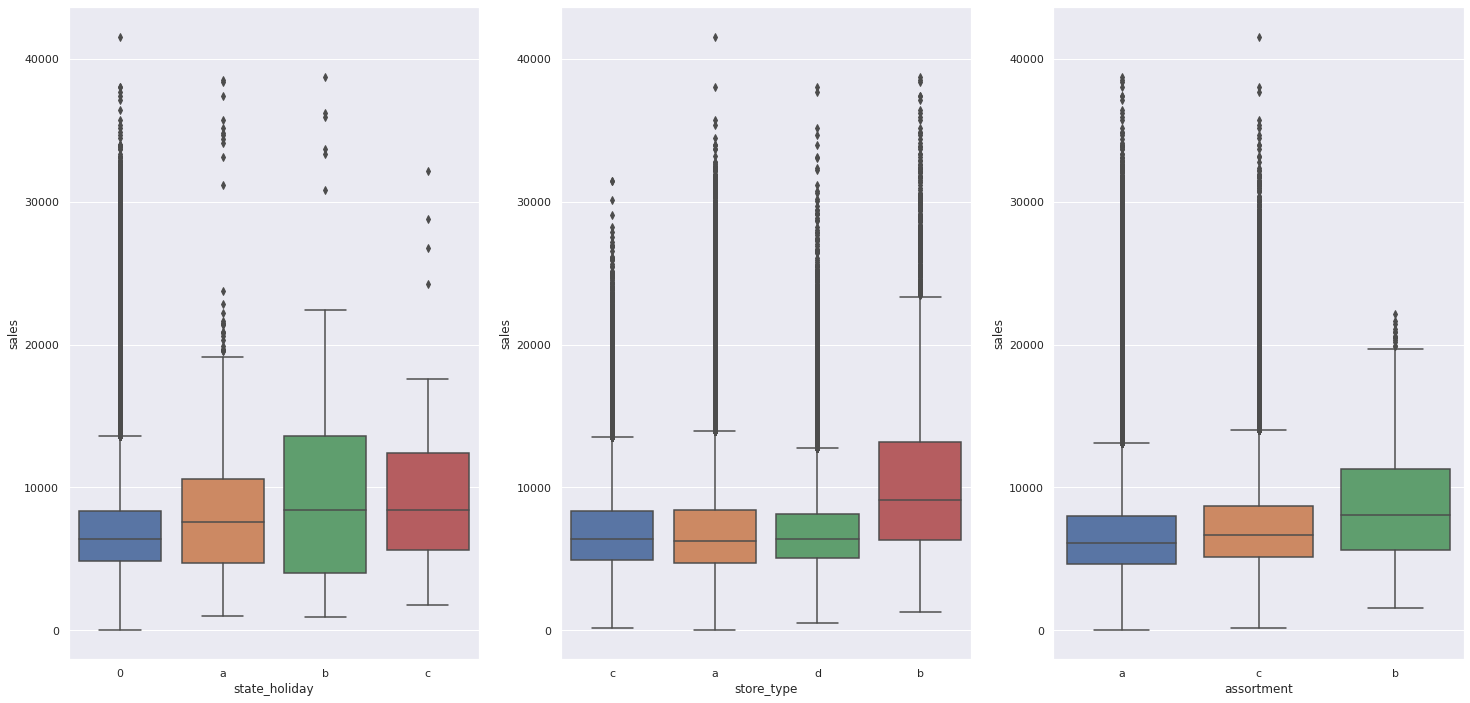

In [30]:
aux1 = df1[(df1['state_holiday'] != 0) & (df1['sales'] != 0)]

plt.subplot(1,3,1)
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.boxplot(x = 'store_type', y = 'sales', data = aux1);

plt.subplot(1,3,3)
sns.boxplot(x = 'assortment', y = 'sales', data = aux1);


# 2.0. STEP 02 - FEATURE ENGINEERING

In [31]:
df2 = df1.copy()

## 2.1. Hypothesis MindMap

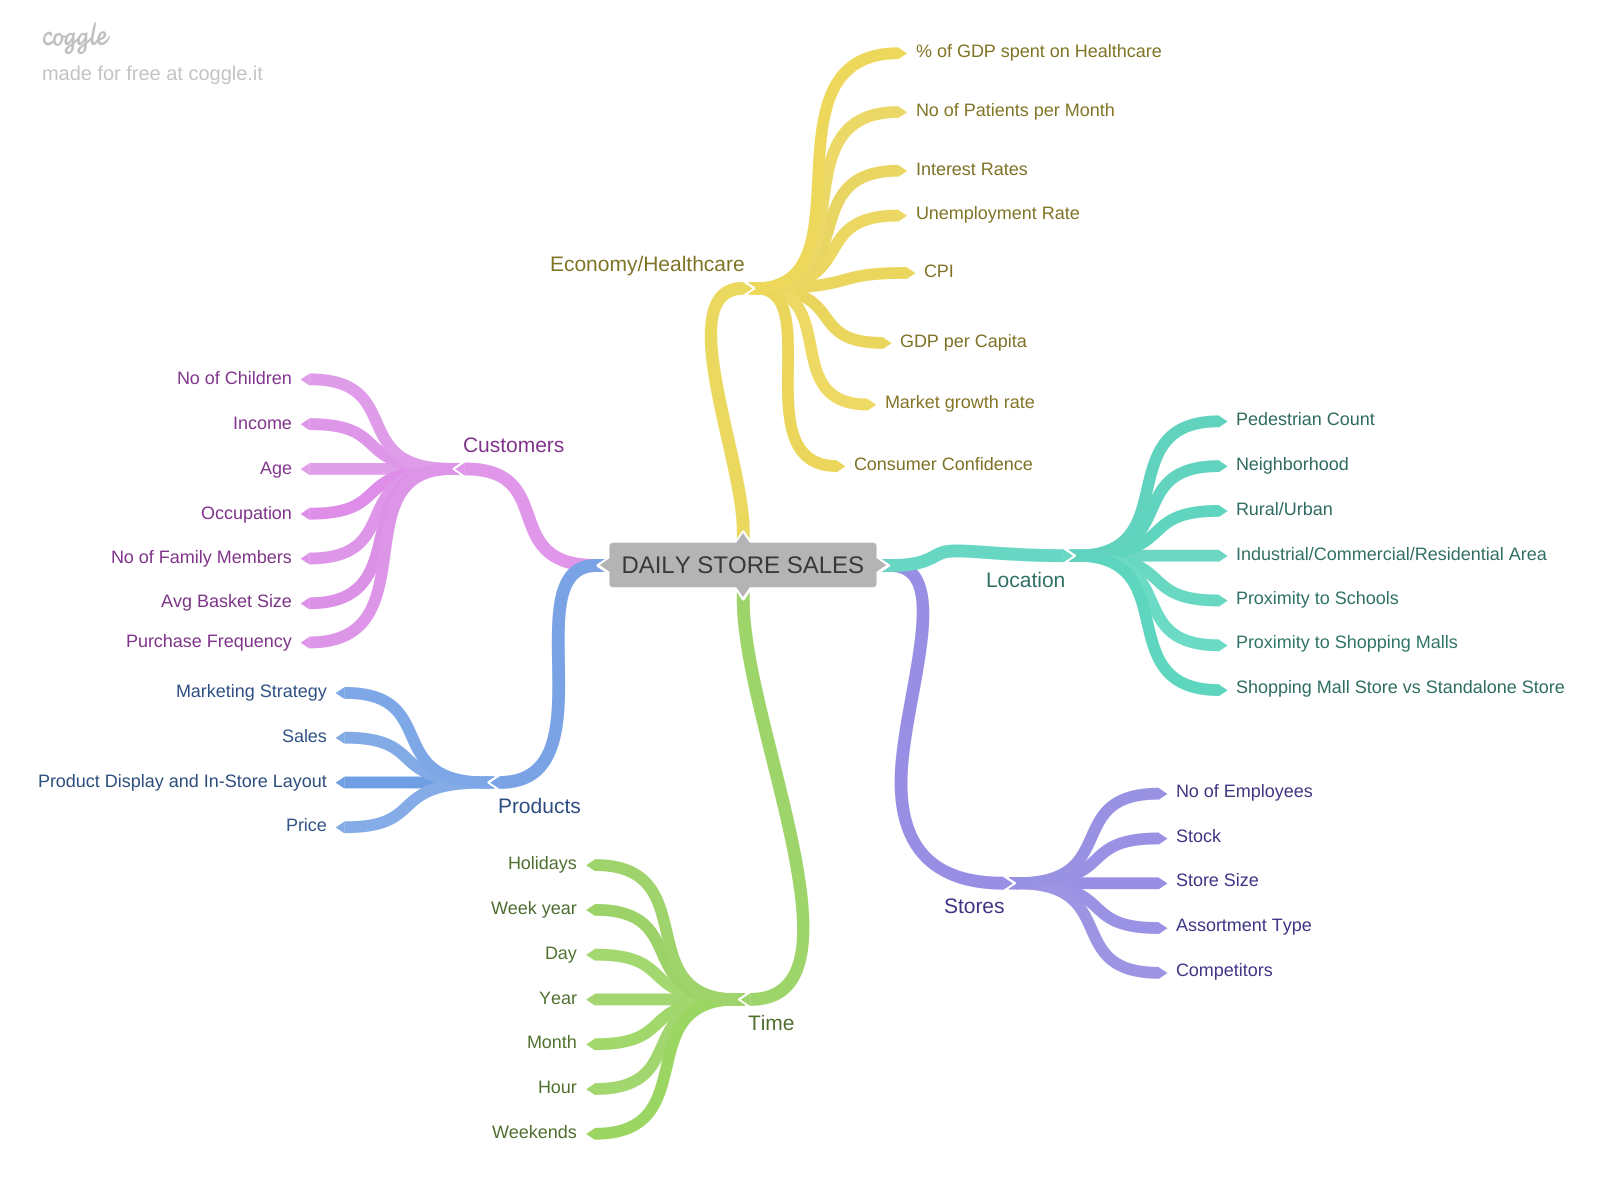

In [32]:
Image('img/DAILY_STORE_SALES.png' )

## 2.2. Hypothesis Creation

### 2.2.1. Stores

**1.**  Stores with more employees sell more  
**2.**  Stores with bigger available stock sell more  
**3.**  Bigger stores sell more  
**4.**  Stores with extended assortment type sell more  
**5.**  Stores near competitors sell less  
**6.**  Stores with newly opened competitors sell less than stores with old competitors  


### 2.2.2. Time

**1.**  Stores sell more on weekdays than weekends/holidays (sales rate)  
**2.**  Stores sell more during the 2nd semester  
**3.**  Stores sell more during summer/winter breaks (schools)    
**4.**  Stores sell less during school holidays  
**5.**  Stores sell more on Christmas than other holidays      
**6.**  Stores are selling more along the years  
**7.**  Stores sell more after day 10 of each month  
**8.**  Stores sell more along the years  


### 2.2.3. Products

**1.**  Stores with higher marketing investments sell more  
**2.**  Stores with products in promotion displayed at the entrance sell more  
**3.**  Stores with cheaper products sell more    
**4.**  Stores with aggresive price strategies sell more  
**5.**  Stores frequently doing standalone promo sales sell more  
**6.**  Stores doing consecutive promo sales in the beginning of the year sell more  
**7.**  Stores participating in consecutive promo for a longer time sell more  
**8.**  Stores with more consecutive promo sale days sell more  

### 2.2.4. Customers 
note: number of customers is not possible to be used on the model unless a customer prediction project is done.

**1.**  Stores with more customers who have children sell more  
**2.**  Stores with more customers who have higher income sell more  
**3.**  Stores with more elderly customers sell more   
**4.**  Stores with more customers who have higher # of family members sell more  
**5.**  Stores with more loyal customers sell more  


### 2.2.5. Location
note: Location of each store is not given. Hypothesis are displayed below just for the purpose of completeness.

**1.**  Stores with higher pedestrian count (front street) sell more  
**2.**  Stores located in an expensive neighborhood sell more  
**3.**  Stores located in urban areas sell more    
**4.**  Stores located in residential areas sell more   
**5.**  Stores near schools sell more  
**6.**  Stores near shopping malls sell more  
**7.**  Stores located inside malls sell more than standalone stores  

### 2.2.6. External Factors (Economy/Healthcare/Weather)
a. Economy: usually macroeconomic data would not be relevant to the model since its impact tend to affect all stores as a whole. However, some macroeconomic data could be relevant if divided by location or month/week. Since such kind of data is difficult to find, some hypotheses are displayed below just for the purpose of completeness.   
b. Healthcare:   
c. Weather: although Rossmann stores are mainly located in Germany,  their location is not present on the dataset. Therefore, the usage of weather as a predictor for this model would be a big assumption to take.

**1.**  Stores within areas with low unemployment rate sell more  
**2.**  Stores within areas with high number of patients sell more  
**3.**  Stores within areas with high Gross Domestic Product Per Capita (GDPpc) sell more    
**4.**  Stores sales increase when GDPpc increases (month)  
**5.**  Stores sales increase when interest rates decrease (month)  
**6.**  Stores sales increase when Consumer Price Index (CPI) rate increases (month)  
**7.**  Stores sales increase when the number of patients hospitalized (per month) increase  
**8.**  Stores sales increase when the air quality gets worse (AQI)  
**9.**  Store sales increase when the weather is above 28ºC or below 18ºC

## 2.3. Viable Hypothesis List

**1.**  Stores with extended assortment type sell more  
**2.**  Stores near competitors sell less  
**3.**  Stores with newly opened competitors sell less than stores with old competitors  
**4.**  Stores sell more on weekdays than weekends/holidays (sales rate)  
**5.**  Stores sell more during the 2nd semester  
**6.**  Stores sell more during summer/winter breaks (schools)    
**7.**  Stores sell less during school holidays  
**8.**  Stores opened during Christmas sell more    
**9.**  Stores are selling more along the years  
**10.**  Stores sell more after day 10 of each month  
**11.**  Stores frequently doing standalone promo sales sell more   
**12.**  Stores doing consecutive promo sales in the beginning of the year sell more  
**13.**  Stores participating in consecutive promo for a longer time sell more  
**14.**  Stores with more consecutive promo sale days sell more   
**15.**  Stores sales increase when GDPpc increases (month)   
**16.**  Stores sales increase when interest rates decrease (month)  
**17.**  Stores sales increase when Consumer Price Index (CPI) rate increases (month)  



## 2.4. Feature Engineering

In [33]:
df2['date'] = pd.to_datetime(df2['date'])

# competition_since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'],
                                                                  month=x['competition_open_since_month'],
                                                                  day=1 ), axis=1 )

# competition_since_month
df2['competition_since_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

# promo2_since
df2['promo2_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo2_since'] = df2['promo2_since'].apply( lambda x: 
                                              datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )

# promo2_time_week
df2['promo2_time_week'] = ((df2['date'] - df2['promo2_since']) / 7).apply(lambda x: x.days).astype(int)

# promo2_time_month
df2['promo2_time_month'] = ((df2['date'] - df2['promo2_since']) / 30).apply(lambda x: x.days).astype(int)

# day, month, year
df2['day'] = df2['date'].dt.day
df2['month'] = df2['date'].dt.month
df2['year'] = df2['date'].dt.year

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# is_weekday
df2['is_weekday'] = df2.apply(lambda x: 1 if x['date'].weekday() in [0,1,2,3,4] 
                              else 1 if x['state_holiday'] == 0
                              else 0, axis = 1)


<ipython-input-33-d989d236c0b9>:28: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [34]:
# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a'
                                            else 'extra' if x == 'b'
                                            else 'extended')
# state_holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a'
                                                  else 'easter' if x == 'b'
                                                  else 'christmas' if x == 'c'
                                                  else 'regular_day')

In [35]:
# creating GDPpc variable
# https://stats.oecd.org/index.aspx?queryid=66948#
gdp = pd.read_csv('data/germany_gdp.csv', low_memory = False)
gdp = gdp.loc[(gdp['Country'] == 'Germany') & (gdp['MEASURE'] == 'HCPCARSA'), :]
gdp.columns.to_list()


gdp['year_quarter'] = gdp['TIME'].apply(lambda x: x.strip())

gdp = gdp.drop(['LOCATION', 'TIME','Country', 'SUBJECT', 'Subject', 'MEASURE', 'Measure', 'FREQUENCY', 'Frequency', 'Period', 
          'Unit Code', 'Unit', 'PowerCode Code', 'PowerCode', 'Reference Period Code', 'Reference Period', 'Flag Codes', 'Flags'], axis = 1)
df2['quarter'] = 0
df2.loc[df2['month'] == 1, 'quarter'] = 'Q1'
df2.loc[df2['month'] == 2,'quarter'] = 'Q1'
df2.loc[df2['month'] == 3,'quarter'] = 'Q1'
df2.loc[df2['month'] == 4,'quarter'] = 'Q2'
df2.loc[df2['month'] == 5,'quarter'] = 'Q2'
df2.loc[df2['month'] == 6,'quarter'] = 'Q2'
df2.loc[df2['month'] == 7,'quarter'] = 'Q3'
df2.loc[df2['month'] == 8,'quarter'] = 'Q3'
df2.loc[df2['month'] == 9,'quarter'] = 'Q3'
df2.loc[df2['month'] == 10,'quarter'] = 'Q4'
df2.loc[df2['month'] == 11,'quarter'] = 'Q4'
df2.loc[df2['month'] == 12, 'quarter'] = 'Q4'
df2['year_quarter'] = df2['year'].astype(str) + '-' + df2['quarter'].astype(str)

df2 = pd.merge(df2, gdp, how = 'left', on = 'year_quarter')

df2['gdp'] = df2['Value']
df2 = df2.drop(['quarter','Value'], axis = 1)

In [36]:
# CPI index (Ref 2015 = 100)
cpi = pd.read_csv('data/cpi_germany.csv', low_memory = False)
# cpi = cpi.loc[(cpi['Country'] == 'Germany') & (cpi['Measure'] == 'Index') & (cpi['Subject'] == 'CPI: 01-12 - All items'), :]
# cpi[['year','month']] = cpi['TIME'].str.split('-',expand = True)
# cpi['year'] = cpi['year'].astype(float).astype(int)
# cpi = cpi[cpi['year'] < 2016]

# cpi.loc[cpi['month'] == '01', 'month'] = '1'
# cpi.loc[cpi['month'] == '02','month'] = '2'
# cpi.loc[cpi['month'] == '03','month'] = '3'
# cpi.loc[cpi['month'] == '04','month'] = '4'
# cpi.loc[cpi['month'] == '05','month'] = '5'
# cpi.loc[cpi['month'] == '06','month'] = '6'
# cpi.loc[cpi['month'] == '07','month'] = '7'
# cpi.loc[cpi['month'] == '08','month'] = '8'
# cpi.loc[cpi['month'] == '09','month'] = '9'
# cpi.loc[cpi['month'] == '10','month'] = '10'
# cpi.loc[cpi['month'] == '11','month'] = '11'
# cpi.loc[cpi['month'] == '12', 'month'] = '12'

# cpi['year_month'] = cpi['year'].astype(str) + '-' + cpi['month'].astype(str)
# cpi['cpi'] = cpi['Value']
# cpi = cpi.drop(['LOCATION', 'Country', 'SUBJECT', 'Subject', 'MEASURE', 'Measure', 'FREQUENCY', 'Frequency',
#  'Unit Code', 'Unit', 'PowerCode Code', 'PowerCode', 'Reference Period Code', 'Reference Period', 'Flag Codes', 'Flags', 'TIME','Time','year','month','Value'], axis = 1)
df2['year_month'] = df2['year'].astype(str) + '-' + df2['month'].astype(str)
df2 = pd.merge(df2, cpi, how = 'left', on = 'year_month')

In [37]:
# interest_rates (Long-term interest rates, Per cent per annum)
interest_rate = pd.read_csv('data/interest_germany.csv', low_memory = False)
interest_rate = interest_rate.loc[(interest_rate['Country'] == 'Germany') & (interest_rate['SUBJECT'] == 'IRLT') & (interest_rate['Unit'] == 'Percentage'), :]
interest_rate[['year','month']] = interest_rate['TIME'].str.split('-',expand = True)
interest_rate['year'] = interest_rate['year'].astype(float).astype(int)
interest_rate = interest_rate[interest_rate['year'] < 2016]

interest_rate.loc[interest_rate['month'] == '01', 'month'] = '1'
interest_rate.loc[interest_rate['month'] == '02','month'] = '2'
interest_rate.loc[interest_rate['month'] == '03','month'] = '3'
interest_rate.loc[interest_rate['month'] == '04','month'] = '4'
interest_rate.loc[interest_rate['month'] == '05','month'] = '5'
interest_rate.loc[interest_rate['month'] == '06','month'] = '6'
interest_rate.loc[interest_rate['month'] == '07','month'] = '7'
interest_rate.loc[interest_rate['month'] == '08','month'] = '8'
interest_rate.loc[interest_rate['month'] == '09','month'] = '9'
interest_rate.loc[interest_rate['month'] == '10','month'] = '10'
interest_rate.loc[interest_rate['month'] == '11','month'] = '11'
interest_rate.loc[interest_rate['month'] == '12', 'month'] = '12'
interest_rate['year_month'] = interest_rate['year'].astype(str) + '-' + interest_rate['month'].astype(str)
interest_rate['interest_rate'] = interest_rate['Value']
interest_rate = interest_rate.drop(['SUBJECT', 'Subject', 'LOCATION', 'Country', 'FREQUENCY', 'Frequency', 'TIME', 'Time', 'Unit Code', 'Unit', 'PowerCode Code', 'PowerCode', 'Reference Period Code', 'Reference Period',
 'Value', 'Flag Codes', 'Flags', 'year', 'month'], axis = 1)
df2 = pd.merge(df2, interest_rate, how = 'left', on = 'year_month')
df2['year_month'] = pd.to_datetime(df2['year_month'])

# 3.0. STEP 03 - FILTERING VARIABLES (according to business restritions)

In [38]:
df3 = df2.copy()

## 3.1. Filtering Rows

In [39]:
# We will exclude closed stores with zero sales
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Column Selection

In [40]:
# customers won't be needed since there is no way to know # of customers by the prediction time. Other columns were auxiliary ones.
cols_drop = ['customers', 'promo_interval', 'open', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

In [41]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo2',
       'competition_since', 'competition_since_month', 'promo2_since',
       'promo2_time_week', 'promo2_time_month', 'day', 'month', 'year',
       'week_of_year', 'year_week', 'is_weekday', 'year_quarter', 'gdp',
       'year_month', 'cpi', 'interest_rate'],
      dtype='object')

In [42]:
df3 = df3[['store', 'date', 'day', 'month', 'year','year_month','week_of_year','year_week','sales','day_of_week','is_weekday','state_holiday','school_holiday',
     'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year',
     'competition_since', 'competition_since_month', 'promo', 'is_promo2','promo2', 'promo2_since', 'promo2_since_week', 
     'promo2_since_year', 'promo2_time_week', 'promo2_time_month','gdp','cpi','interest_rate']]

# 4.0. STEP 04 - EXPLORATORY DATA ANALYSIS

In [43]:
# df3.to_csv(r'data/df3.csv', index = False)
#df4 = pd.read_csv('data/df3.csv', low_memory = False)
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Target Variable

/home/alan/.pyenv/versions/3.8.1/envs/StoreSales/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


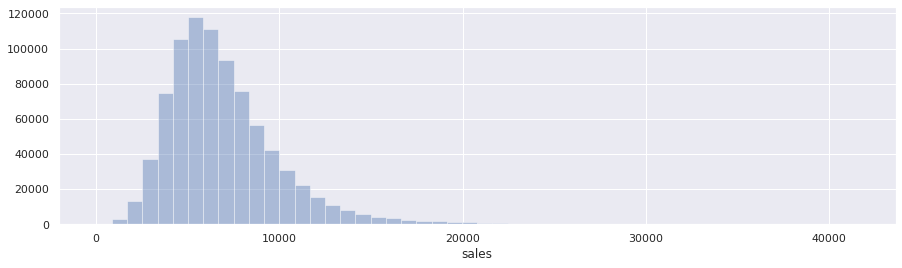

In [44]:
# we will need to pre-process
plt.figure(figsize = (15, 4))
sns.distplot(df4['sales'], kde = False);

### 4.1.2. Numerical Variables

In [45]:
num_feat = df4.select_dtypes( include = ['int64', 'float64'])

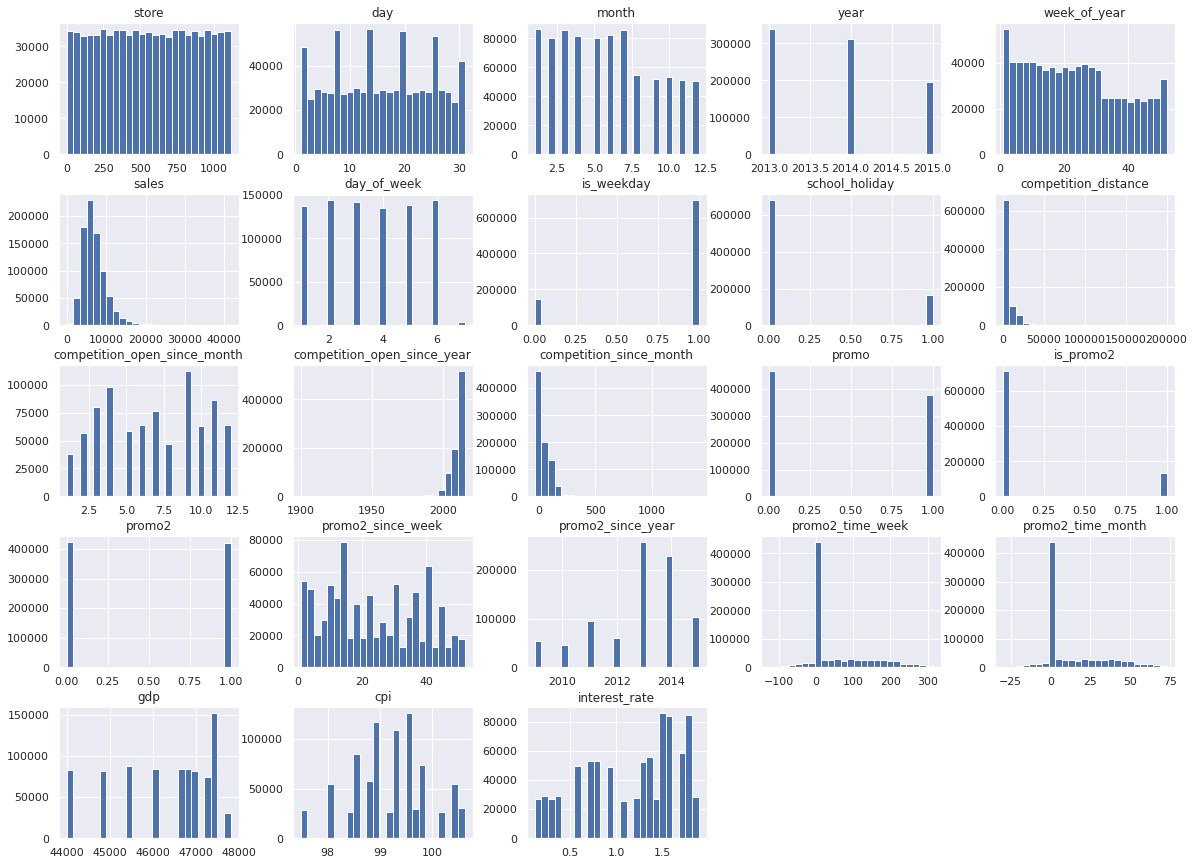

In [46]:
num_feat.hist(bins = 25, figsize = (20,15));

 **Overall: All variables don't follow a normal distribution**  
 **day**: There are specific days which has almost double sales data points than others (day)  
 **month**: More sales data points on the first semester  
 **year**: Less data points in 2015 (compared to other years)  
 **week_of_year**: A boom of sales data points during the first weeks of the year  
 **day_of_week**: less sales data points on sundays    
 **is_weekday**: more sales data points on weekdays  
 **school_holiday**: more sales data points on regular days  
 **competition_distance**: more sales data points for stores with closer competitors  
 **competition_open_since_month**: more sales data points for competitors which entered competition on April, July, September  
 **competition_since_month**: no relevant info retrieved  
 **is_promo2**: more sales data points for 0  
 **competition_open_since_year, promo2, promo, promo_since, promo_time, gdp, cpi, interest_rates**: no relevant info retrieved  


### 4.1.3. Categorical Variables

In [47]:
cat_feat = df4.select_dtypes(exclude = ['float64','int64'])
cat_feat.columns

Index(['date', 'year_month', 'year_week', 'state_holiday', 'store_type',
       'assortment', 'competition_since', 'promo2_since'],
      dtype='object')

/home/alan/.pyenv/versions/3.8.1/envs/StoreSales/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/alan/.pyenv/versions/3.8.1/envs/StoreSales/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/alan/.pyenv/versions/3.8.1/envs/StoreSales/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit 

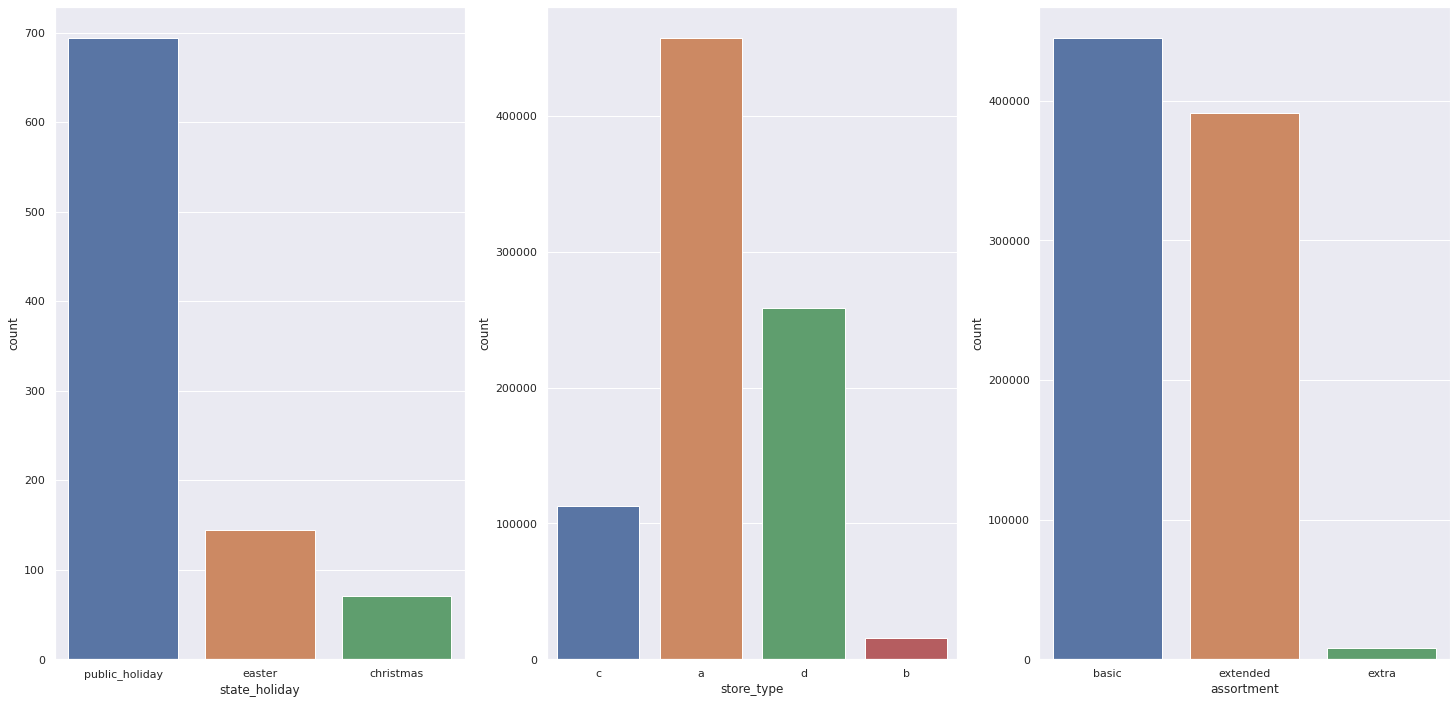

In [48]:
# state_holiday
plt.subplot(1,3,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

# store_type
plt.subplot(1,3,2)
sns.countplot(df4['store_type'])

# assortment
plt.subplot(1,3,3)
sns.countplot(df4['assortment']);



 **state_holiday**: more sales data points on public_holidays than other holidays. Easter and Christmas are similar  
 **store_type**: More sales data points for store_type a. Less stores b  
 **assortment**: Less sales data points for assortment of type 'extra'  


## 4.2. Bivariate Analysis

### **H1.**  Stores with bigger assortment type (categorized as 'extra') sell more  
**False**: Stores with bigger assortment sell less. However, the number of data points for stores with assortment 'extra' is very low compared to the other two (refer to univariate analysis on 4.1.3. )

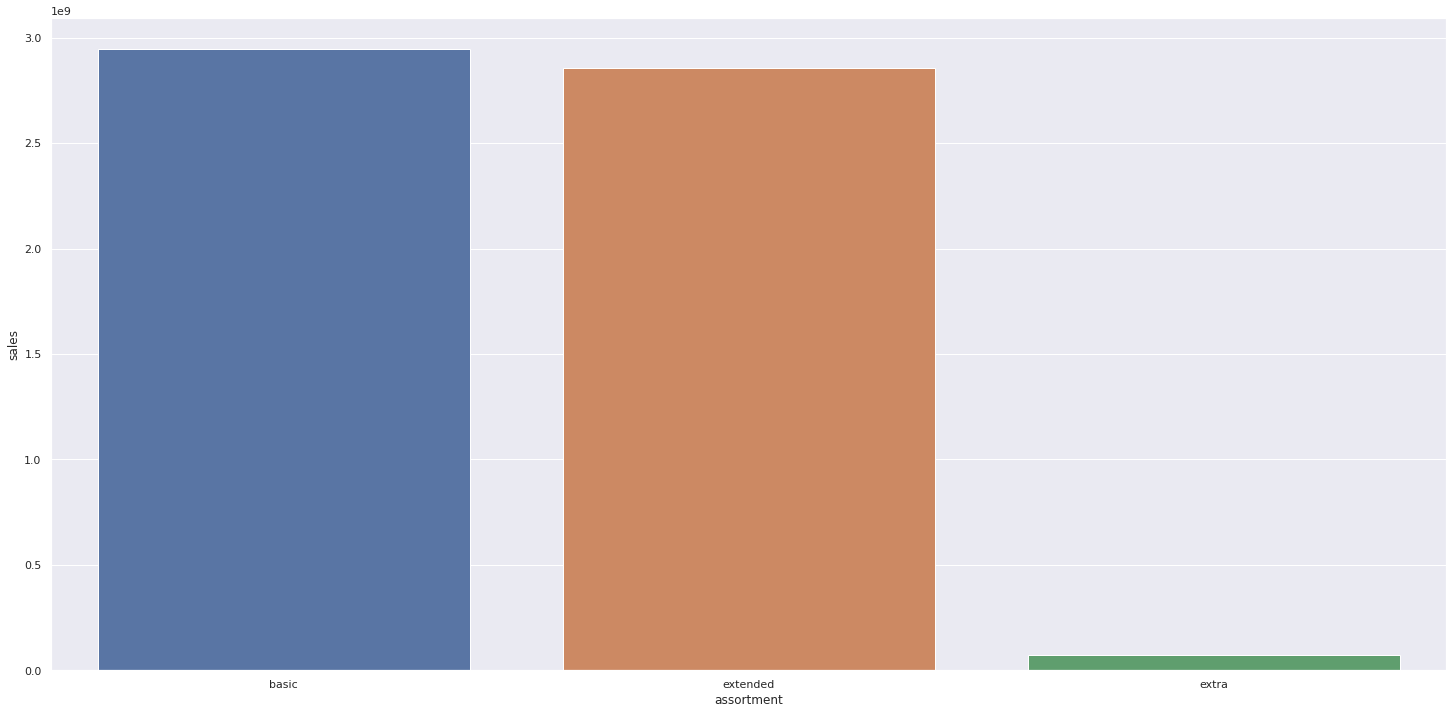

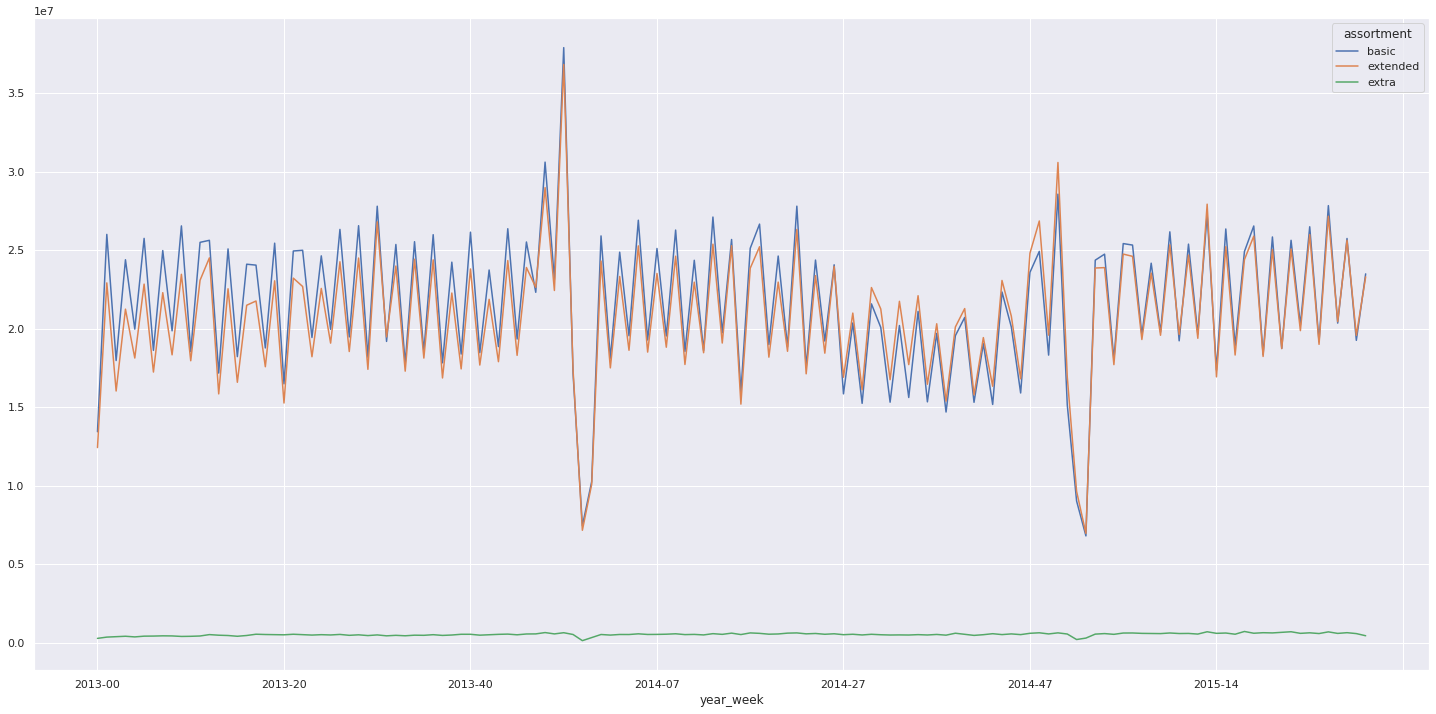

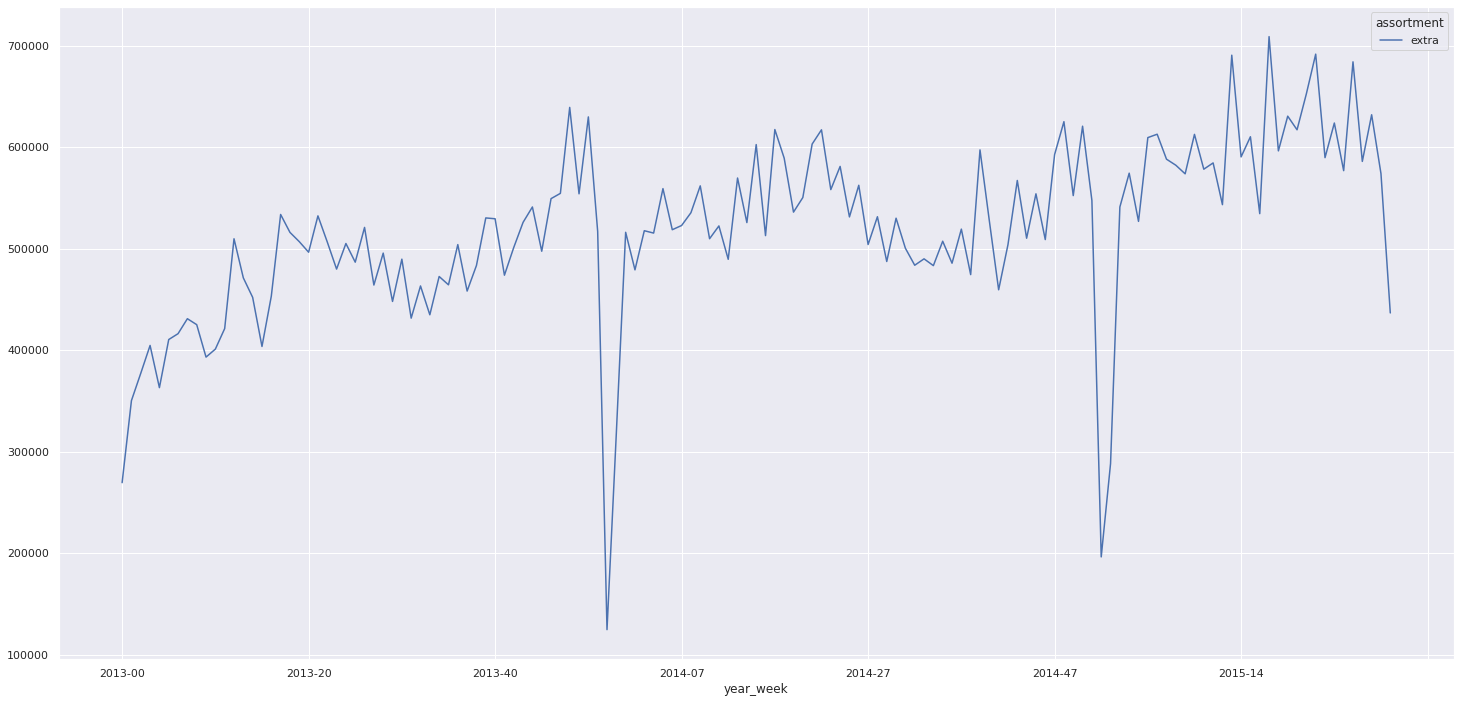

In [49]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = aux1);

aux2 = df4[['assortment','sales','year_week']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot();

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot();

### **H2.**  Stores near competitors sell less  
**FALSE**: Stores near competitors sell more.

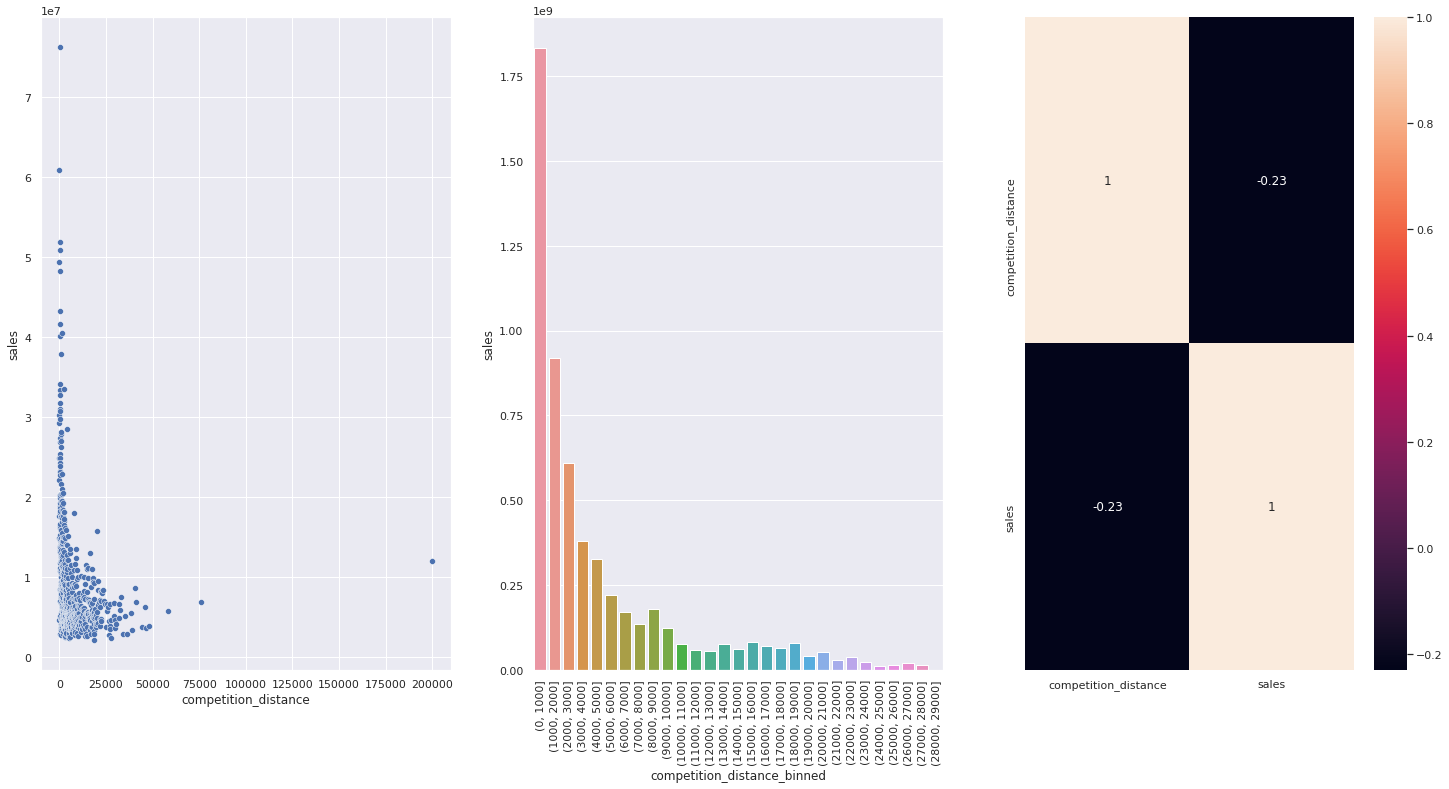

In [54]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
plt.subplot(1,3,1)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1)

plt.subplot(1,3,2)
bins = list(np.arange(0,30000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(), annot = True);
plt.show()

### **H3.**  Stores with newly opened competitors sell less than stores with old competitors  
**FALSE**: Stores with newly opened competitors sell more.

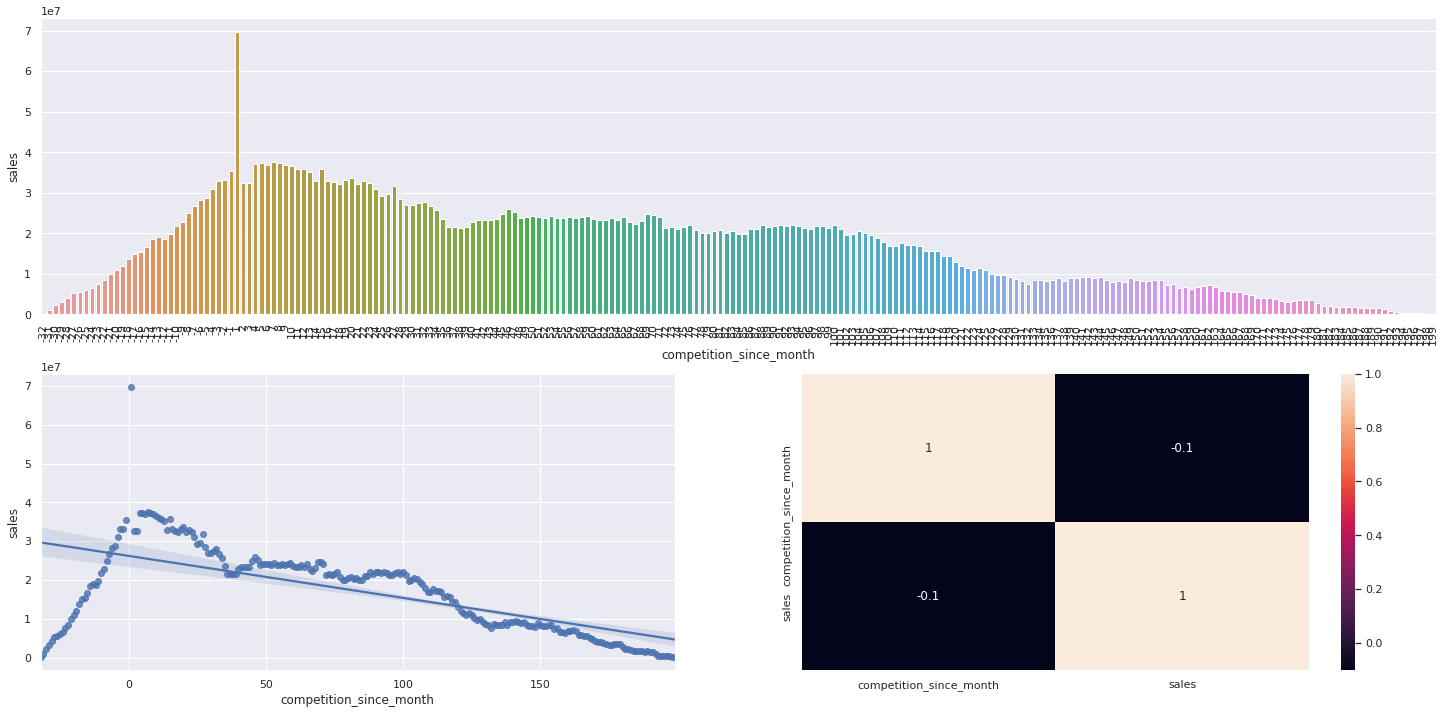

In [55]:
grid = GridSpec( 2, 2 )

plt.subplot(grid[0,:])
aux1 = df4[['competition_since_month', 'sales']].groupby('competition_since_month').sum().reset_index()
aux2 = aux1[(aux1['competition_since_month'] != 0) & (aux1['competition_since_month'] < 200)]
sns.barplot(x = 'competition_since_month', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(grid[1,0])
sns.regplot(x = 'competition_since_month', y = 'sales', data = aux2)

plt.subplot(grid[1,1])
sns.heatmap(aux1.corr(), annot = True);

### **H4.**  Stores sell more on weekdays than weekends/holidays (sales rate)  
**TRUE**: Stores sell more on weekdays. Sales volume is also bigger on weekdays. Worst sales day is Sunday.

,Metrics,Results
0,Total Sales,5873180623
1,Total Sales Weekends,875869168
2,Avg Sales Weekends,5932.26
3,Total Sales Weekdays,4997311455
4,Avg Sales Weekdays,7172.9


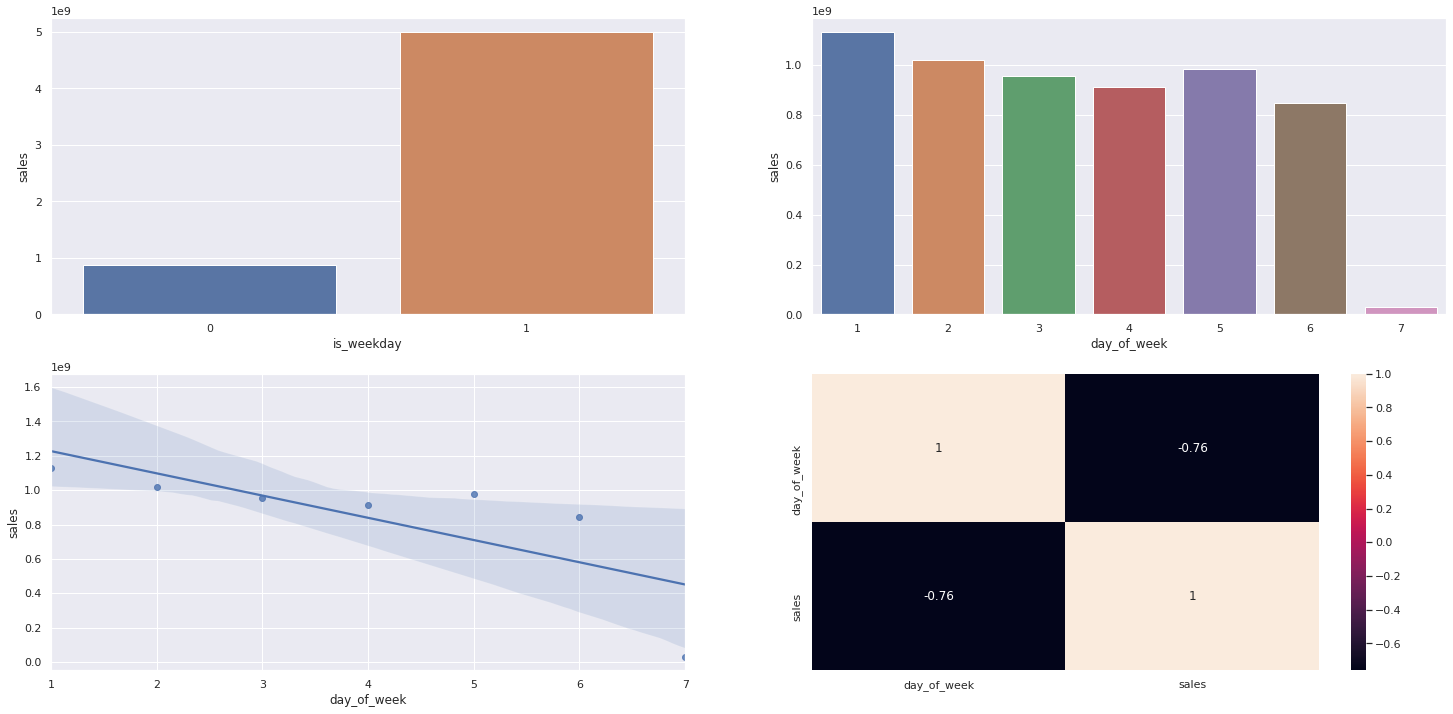

In [56]:
aux1 = df4[['is_weekday','sales']].groupby('is_weekday').sum().reset_index()
plt.subplot(221)
sns.barplot(x = 'is_weekday', y = 'sales', data = aux1);

plt.subplot(222)
aux8 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x = 'day_of_week', y = 'sales', data = aux8);

plt.subplot(223)
sns.regplot(x = 'day_of_week', y = 'sales', data = aux8);

plt.subplot(224)
sns.heatmap(aux8.corr(), annot=True)

aux6 = df4['sales'].sum()
aux2 = df4[df4['is_weekday'] == 0]['sales'].sum()
aux3 = df4[df4['is_weekday'] == 1]['sales'].sum()
aux4 = str(round(df4[df4['is_weekday'] == 0]['sales'].mean(), 2))
aux5 = str(round(df4[df4['is_weekday'] == 1]['sales'].mean(), 2))

data = {'Metrics':['Total Sales', 'Total Sales Weekends','Avg Sales Weekends', 'Total Sales Weekdays',
                   'Avg Sales Weekdays'],'Results': [aux6, aux2, aux4, aux3, aux5]}

aux7 = pd.DataFrame(data)
aux7

### **H5.**  Stores sell more during the 2nd semester  
**FALSE**: Stores sell more on the 1st semester

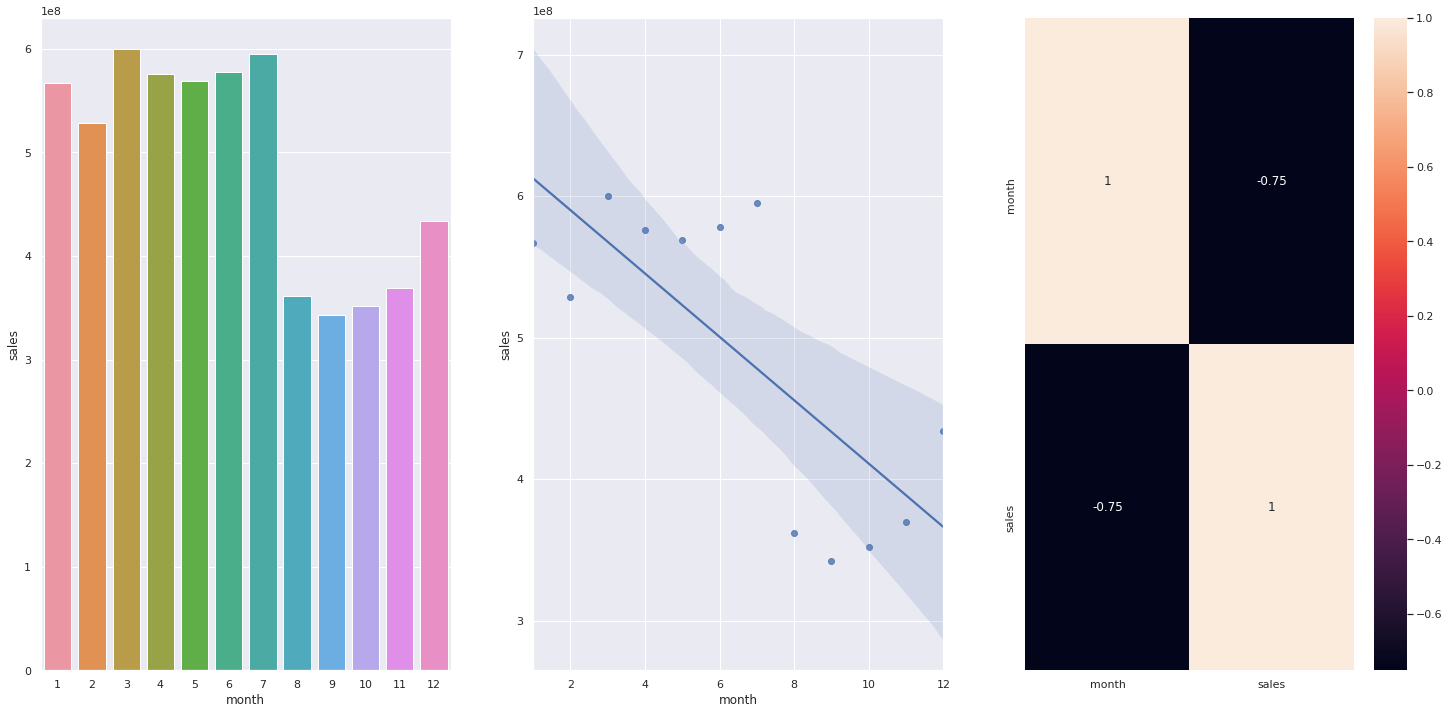

In [57]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()
plt.subplot(1,3,1)
sns.barplot(x = 'month', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x = 'month', y = 'sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(), annot = True);

### **H6.**  Stores sell more during summer/winter breaks (schools)    
**FALSE**: School holidays in Germany are scattered throughout the year. The longest school holidays is the summer break in August and mid-September. DUring these months, stores sell less (refer to barplot above - H5)

### **H7.**  Stores sell less during school holidays  
**TRUE**: Stores sell less during school holidays except in August

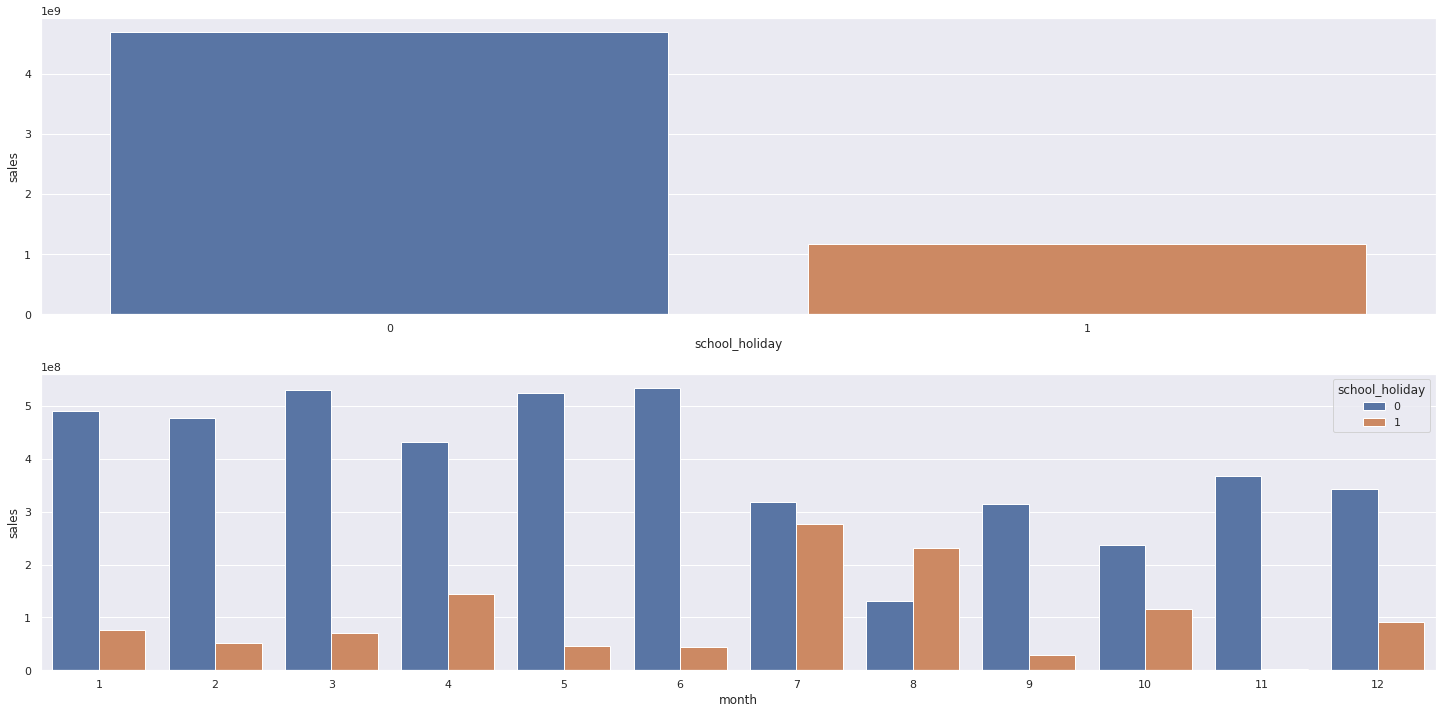

In [58]:
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(211)
sns.barplot(x = 'school_holiday', y = 'sales', data = aux1);

aux2 = df4[['school_holiday','sales', 'month']].groupby(['school_holiday', 'month']).sum().reset_index()
plt.subplot(212)
sns.barplot(x = 'month', y= 'sales' , hue = 'school_holiday', data = aux2);

### **H8.**  Stores sell more on Christmas than other holidays
**FALSE**: Stores sell more on public_holidays and Easter

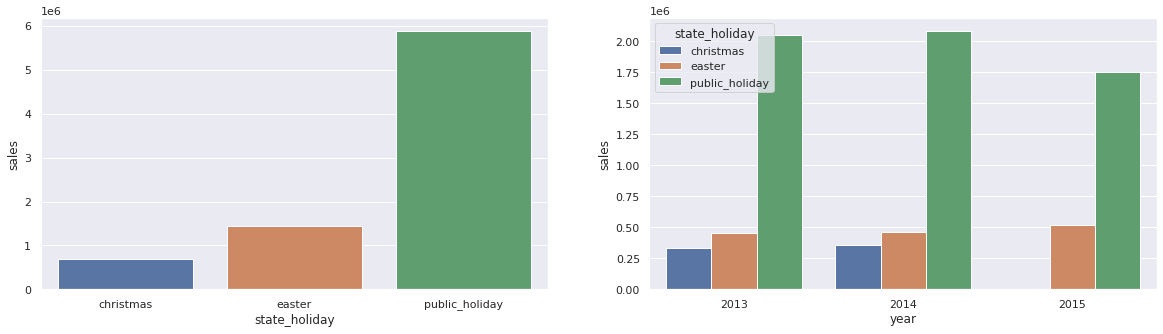

In [59]:
aux1 = df4[df4['state_holiday'] != 'regular_day']
aux2 = aux1[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
plt.figure(figsize = (20,5))
plt.subplot(121)
sns.barplot(x='state_holiday',y='sales',data=aux2);

aux3 = aux1[['state_holiday', 'sales','year']].groupby(['year','state_holiday']).sum().reset_index()
plt.subplot(122)
sns.barplot(x='year',y='sales', hue = 'state_holiday', data=aux3);

### **H9.**  Stores are selling more along the years  
**FALSE**: Stores are selling less along the years. However, the year 2015 is not closed (dataset goes till April 2015)

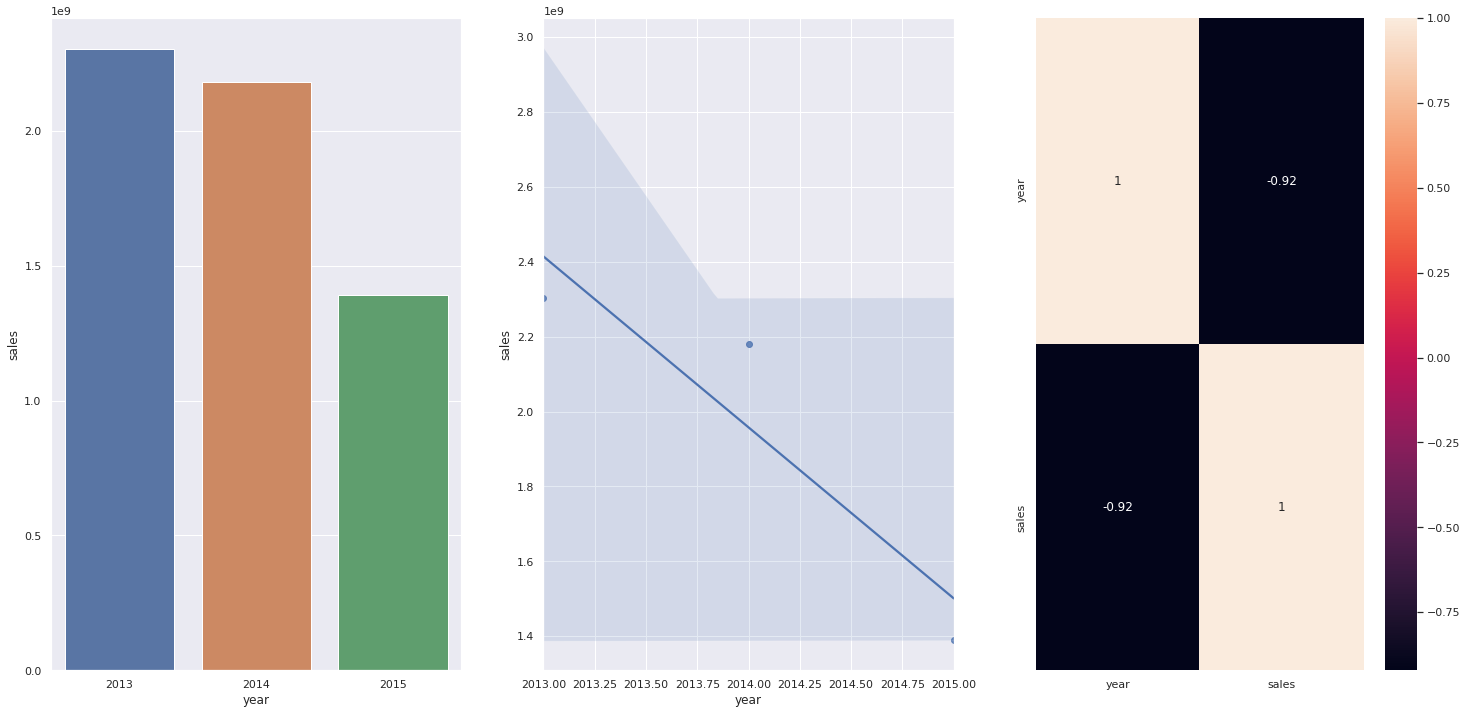

In [60]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(131)
sns.barplot(x = 'year', y = 'sales', data = aux1);

plt.subplot(132)
sns.regplot(x = 'year', y = 'sales', data = aux1);

plt.subplot(133)
sns.heatmap(aux1.corr(), annot = True);


### **H10.**  Stores sell more after day 10 of each month 
**TRUE**: Stores sell more after day 10. Not a surprise, since there are more days after day 10.

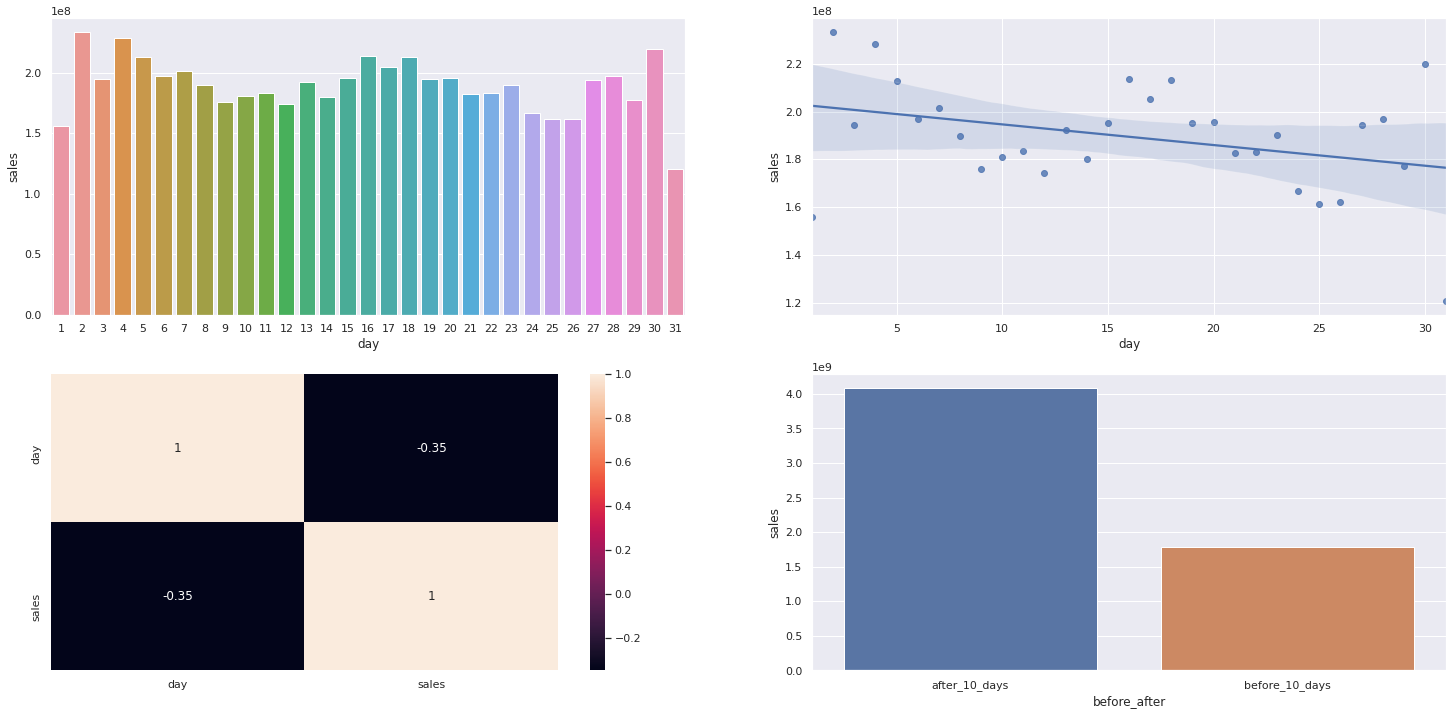

In [61]:

aux1 = df4[['day','sales']].groupby('day').sum().reset_index()
plt.subplot(221)
sns.barplot(x = 'day',y = 'sales', data = aux1);

plt.subplot(222)
sns.regplot(x = 'day',y = 'sales', data = aux1);

plt.subplot(223)
sns.heatmap(aux1.corr(), annot = True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x < 10
                                         else 'after_10_days')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()
plt.subplot(224)
sns.barplot(x = 'before_after',y = 'sales', data = aux2);


### **H11.**  Stores frequently doing traditional promo sales sell more   
**TRUE**: Stores with more traditional promo sales days sell more

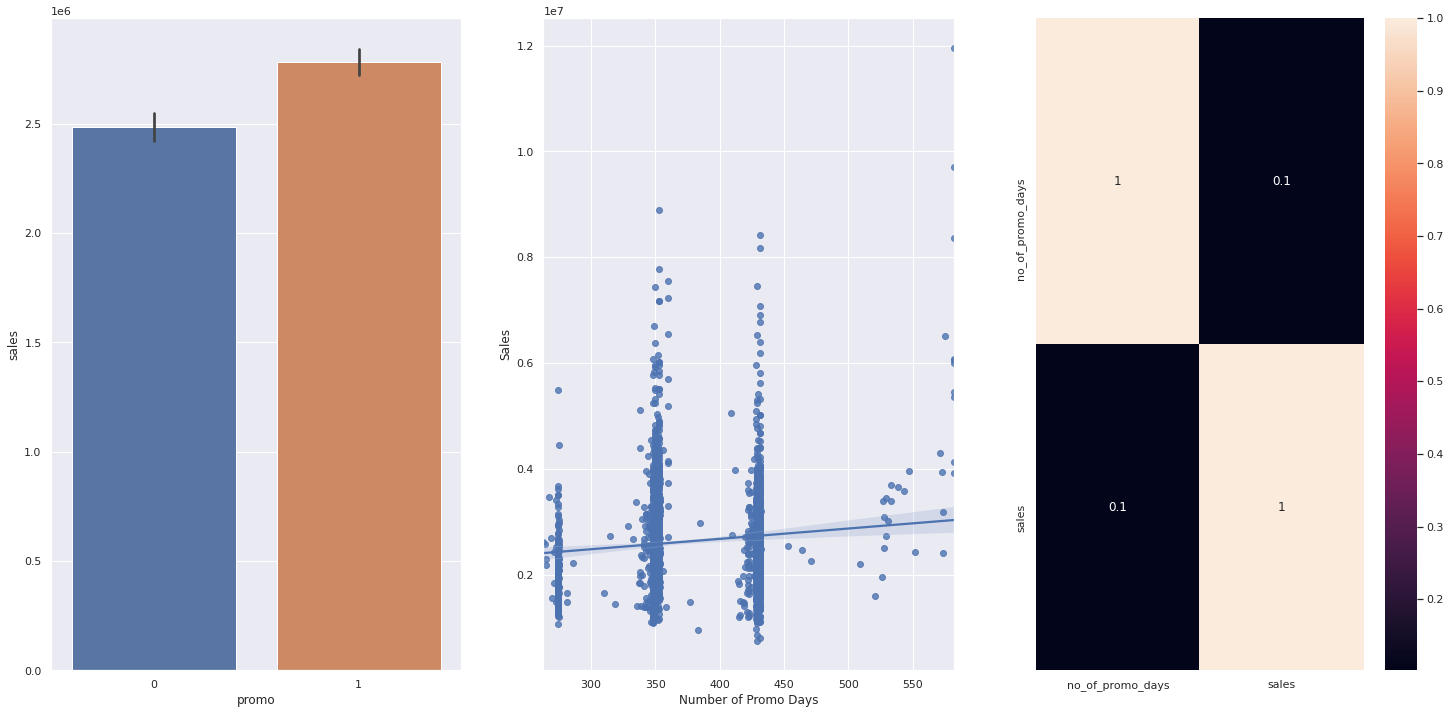

In [62]:
aux1 = df4[['store','promo','sales']].groupby(['store','promo']).sum().reset_index()
plt.subplot(131)
sns.barplot(x = 'promo', y = 'sales', data = aux1);

plt.subplot(132)
aux3 = df4[['store','promo','sales']].groupby(['store','promo']).count().reset_index()
aux1['no_of_promo_days'] = aux3['sales']

sns.regplot(x = 'no_of_promo_days', y = 'sales', data = aux1);
plt.xlabel('Number of Promo Days');
plt.ylabel('Sales');
 

plt.subplot(133)
aux2 = aux1[['no_of_promo_days','sales']]
sns.heatmap(aux2.corr(), annot = True);


### **H12.**  Stores doing consecutive promo sales in the beginning of the year sell more 
**TRUE**: Stores with consecutive promo sales sell more in the beginning of the year. However, sales are unstable for February.

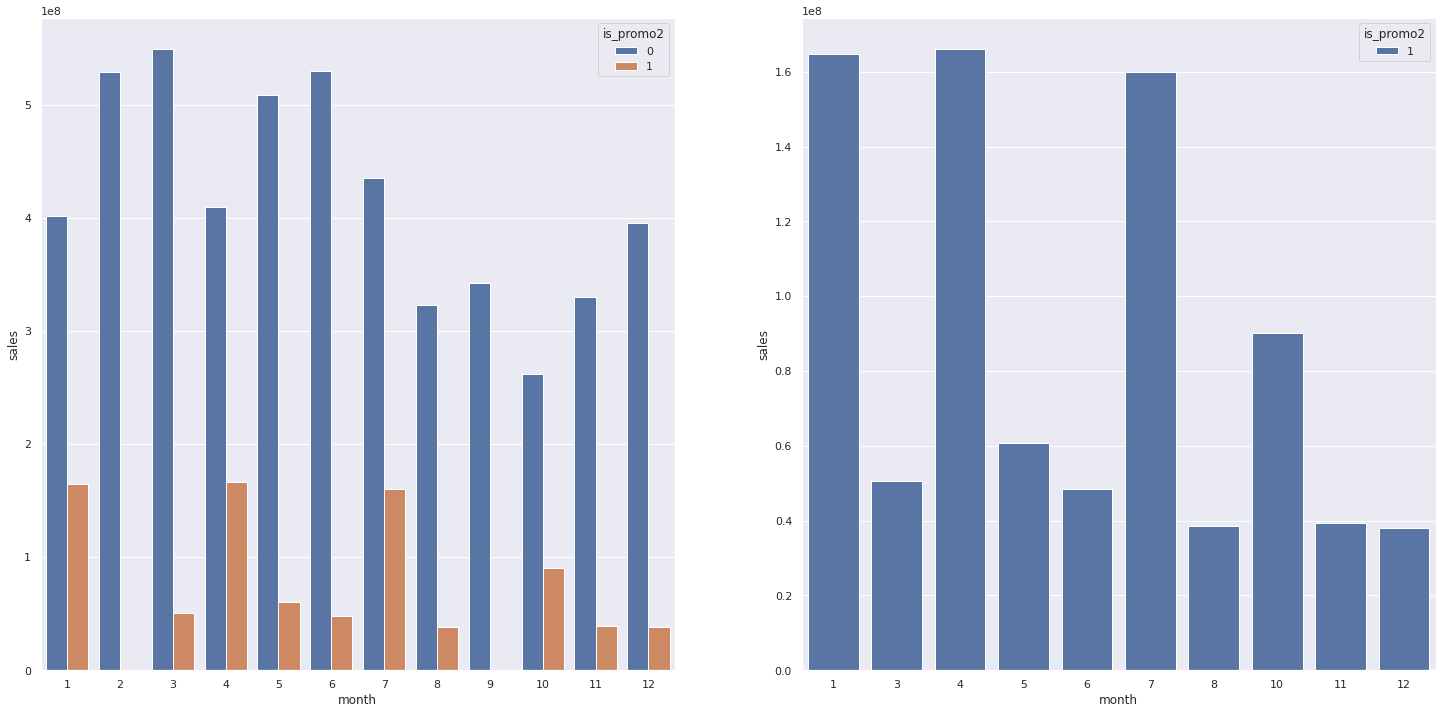

In [64]:
aux1 = df4[['sales','month','is_promo2']].groupby(['is_promo2','month']).sum().reset_index()

plt.subplot(121)
sns.barplot(x = 'month', y = 'sales', hue = 'is_promo2', data = aux1);

aux2 = aux1[aux1['is_promo2'] == 1]
plt.subplot(122)
sns.barplot(x = 'month', y = 'sales', hue = 'is_promo2', data = aux2);


### **H13.**  Stores participating in consecutive promo for a longer time sell more 
**FALSE**: Stores participating in consecutive promo for a longer time sell less.

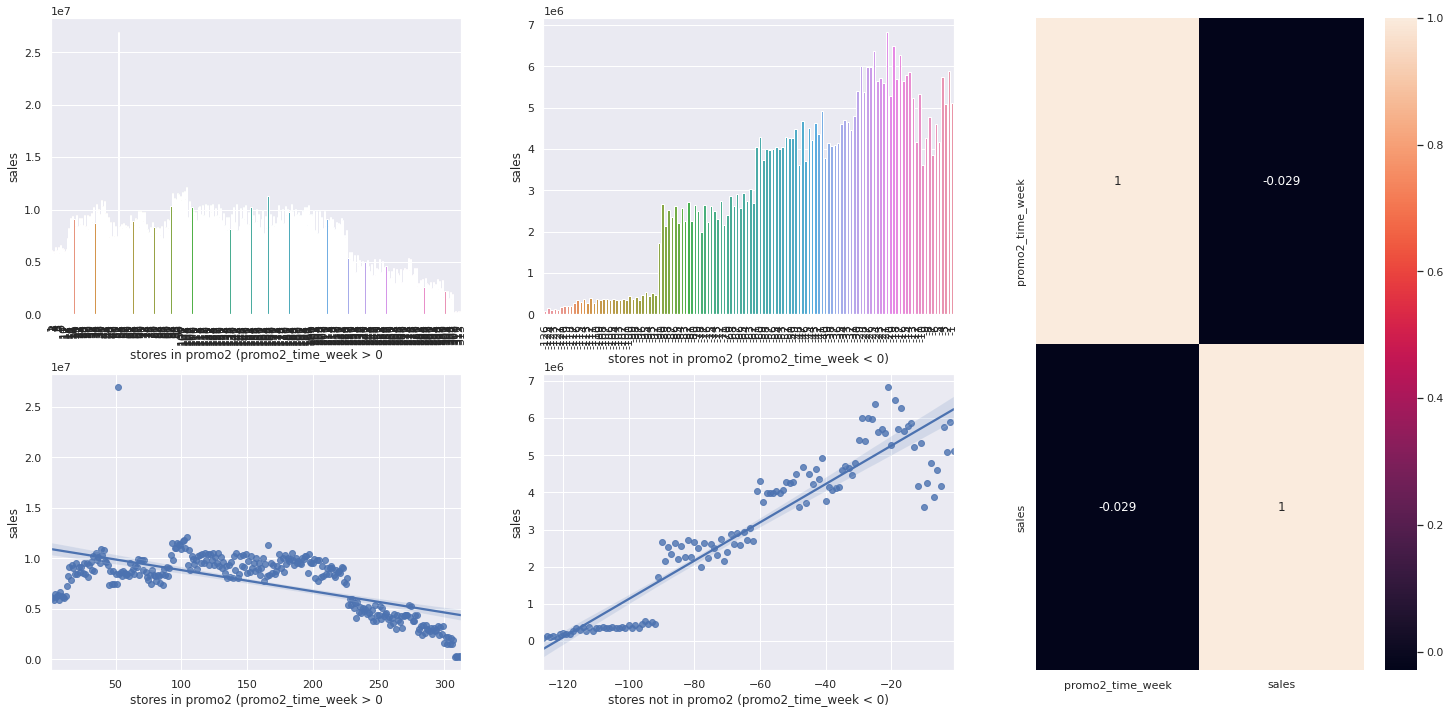

In [65]:
aux1 = df4[['promo2_time_week', 'sales']].groupby( 'promo2_time_week').sum().reset_index()

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo2_time_week'] > 0] # consecutive promo
sns.barplot(x = 'promo2_time_week', y = 'sales', data = aux2);
plt.xticks(rotation = 90);
plt.xlabel('stores in promo2 (promo2_time_week > 0')

plt.subplot(grid[0,1])
aux3 = aux1[aux1['promo2_time_week'] < 0] # regular promo
sns.barplot(x = 'promo2_time_week', y = 'sales', data = aux3);
plt.xticks(rotation=90);
plt.xlabel('stores not in promo2 (promo2_time_week < 0)')

plt.subplot(grid[1,0])
sns.regplot(x = 'promo2_time_week', y = 'sales', data = aux2);
plt.xlabel('stores in promo2 (promo2_time_week > 0')

plt.subplot(grid[1,1])
sns.regplot(x = 'promo2_time_week', y = 'sales', data = aux3);
plt.xlabel('stores not in promo2 (promo2_time_week < 0)')

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr( method='pearson' ), annot=True);

### **H14.**  Stores with more consecutive promo sale days sell more  
**TRUE**: Stores with more consecutive promo days sell more. However, sales volume is bigger for days with no consecutive promotion   
OBS: It might be worth including number of consecutive promo days as a variable in the model. We will add this depending on the ML performance.

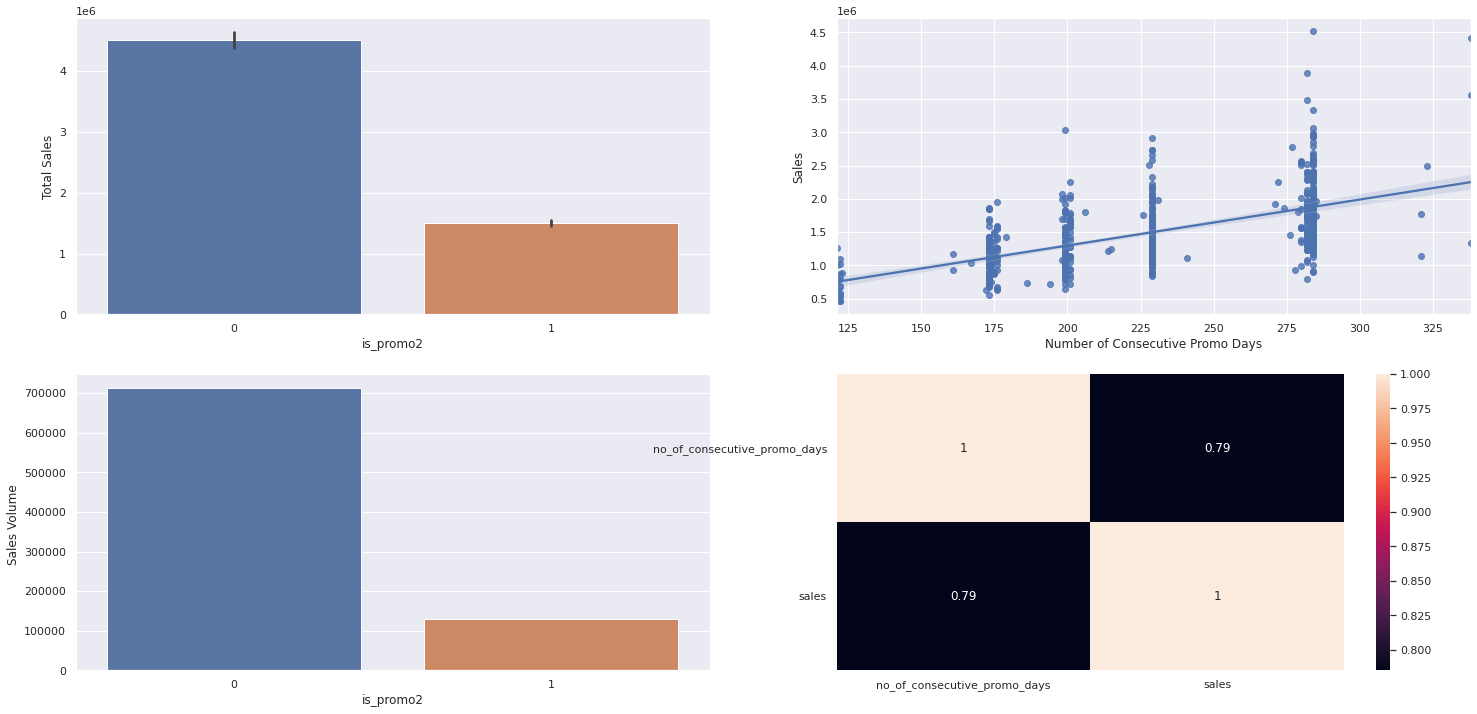

In [66]:
aux1 = df4[['store','is_promo2','sales']].groupby(['store','is_promo2']).sum().reset_index()
plt.subplot(221)
sns.barplot(x = 'is_promo2', y = 'sales', data = aux1);
plt.ylabel('Total Sales');

plt.subplot(222)
aux3 = df4[['store','is_promo2','sales']].groupby(['store','is_promo2']).count().reset_index()
aux1['no_of_consecutive_promo_days'] = aux3['sales']
aux4 = aux1[aux1['is_promo2'] == 1]
sns.regplot(x = 'no_of_consecutive_promo_days', y = 'sales', data = aux4);
plt.xlabel('Number of Consecutive Promo Days');
plt.ylabel('Sales');
 
plt.subplot(223)
aux5 = aux1[['is_promo2','no_of_consecutive_promo_days']].groupby('is_promo2').sum().reset_index()
sns.barplot(x = 'is_promo2', y = 'no_of_consecutive_promo_days', data = aux5);
plt.ylabel('Sales Volume ');

plt.subplot(224)
aux2 = aux1[['no_of_consecutive_promo_days','sales']]
sns.heatmap(aux2.corr(), annot = True);


### **H15.**  Stores sales increase when GDPpc increases (month)   
**FALSE**: Store sales neither increase nor decrease with GDPpc fluctuations over time.

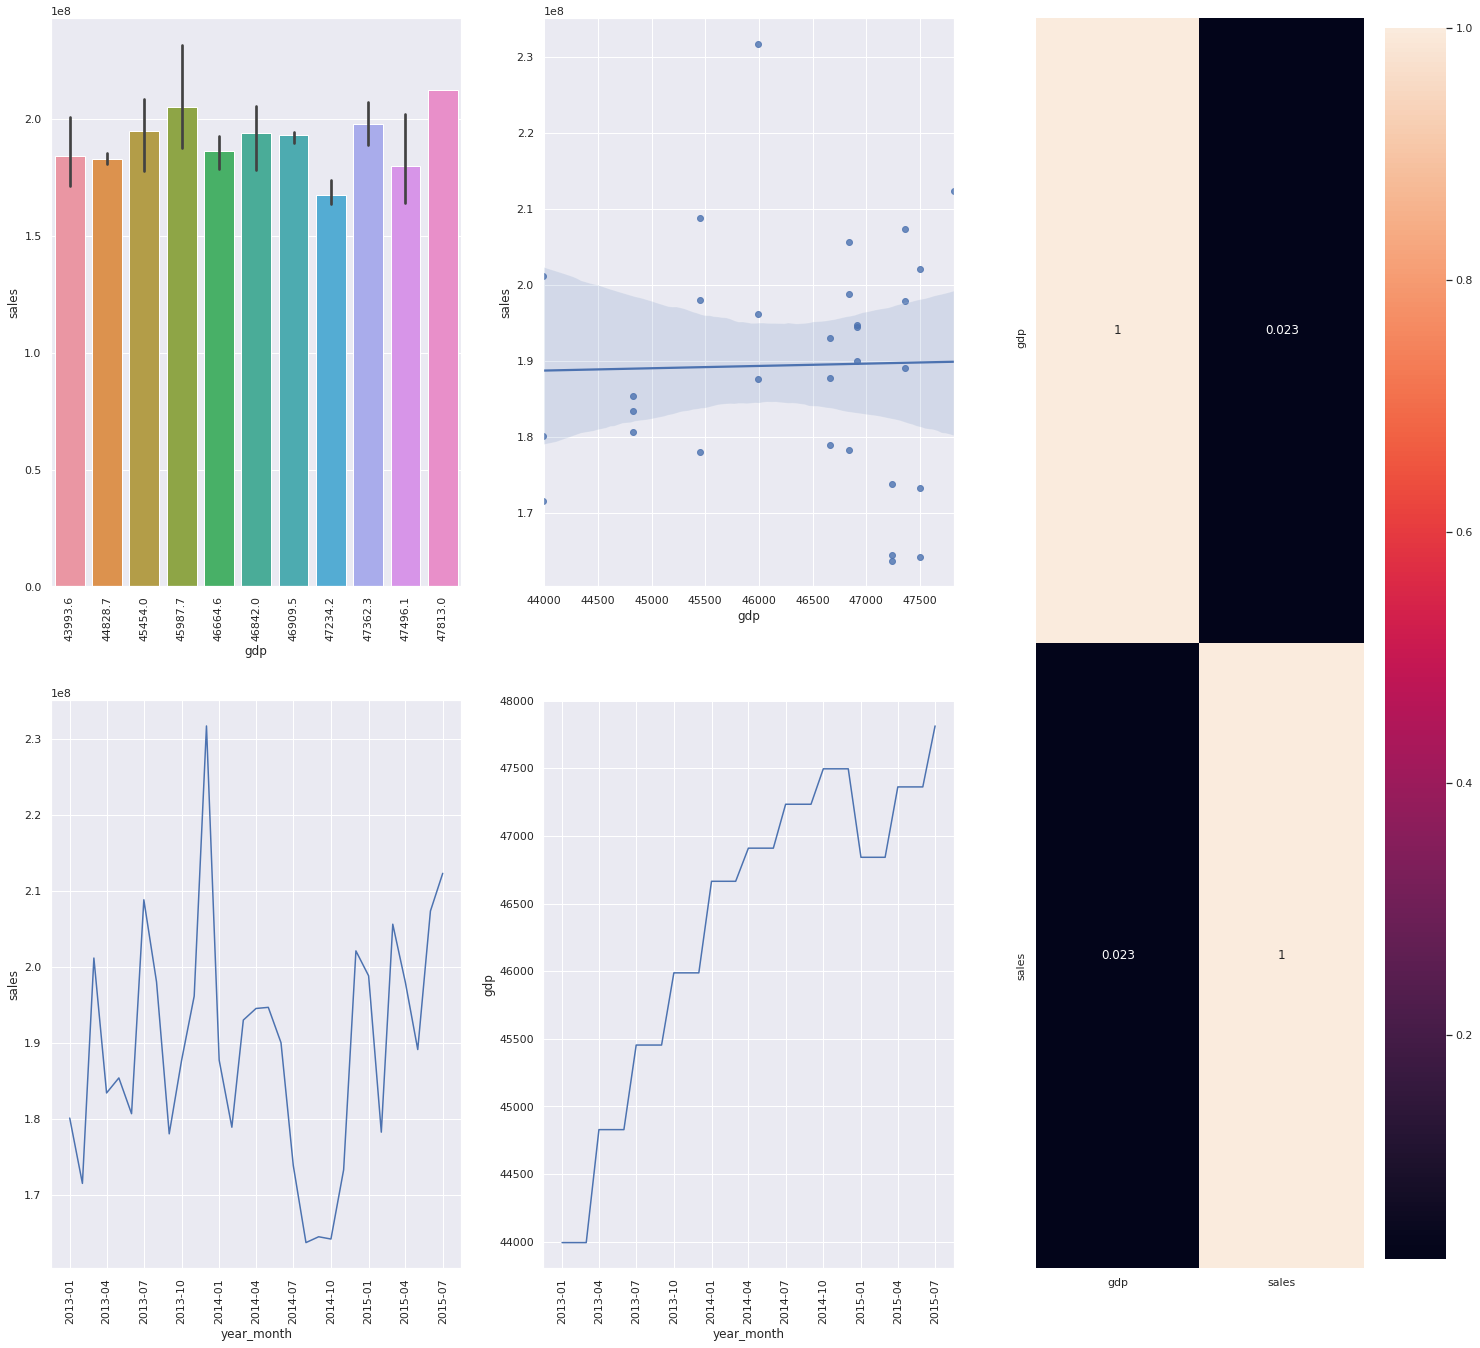

In [67]:
aux1 = df4[['year_month', 'gdp','sales']].groupby(['year_month','gdp']).sum().reset_index()

grid = GridSpec(2,3)
plt.figure(figsize = (25,23))
plt.subplot(grid[0,0])
sns.barplot(x = 'gdp', y = 'sales', data = aux1);
plt.xticks(rotation = 90);

plt.subplot(grid[0,1])
sns.regplot(x = 'gdp', y = 'sales', data = aux1);

plt.subplot(grid[1,0])
sns.lineplot(x = 'year_month', y = 'sales', data = aux1);
plt.xticks(rotation = 90);

plt.subplot(grid[:,2])
aux2 = aux1[['gdp','sales']]
sns.heatmap(aux2.corr(), annot = True);

plt.subplot(grid[1,1])
sns.lineplot(x = 'year_month', y = 'gdp', data = aux1);
plt.xticks(rotation = 90);



### **H16.**  Stores sales increase when interest rates decrease (month)  
**FALSE**: Store sales neither increase nor decrease with interest rate fluctuations over time.

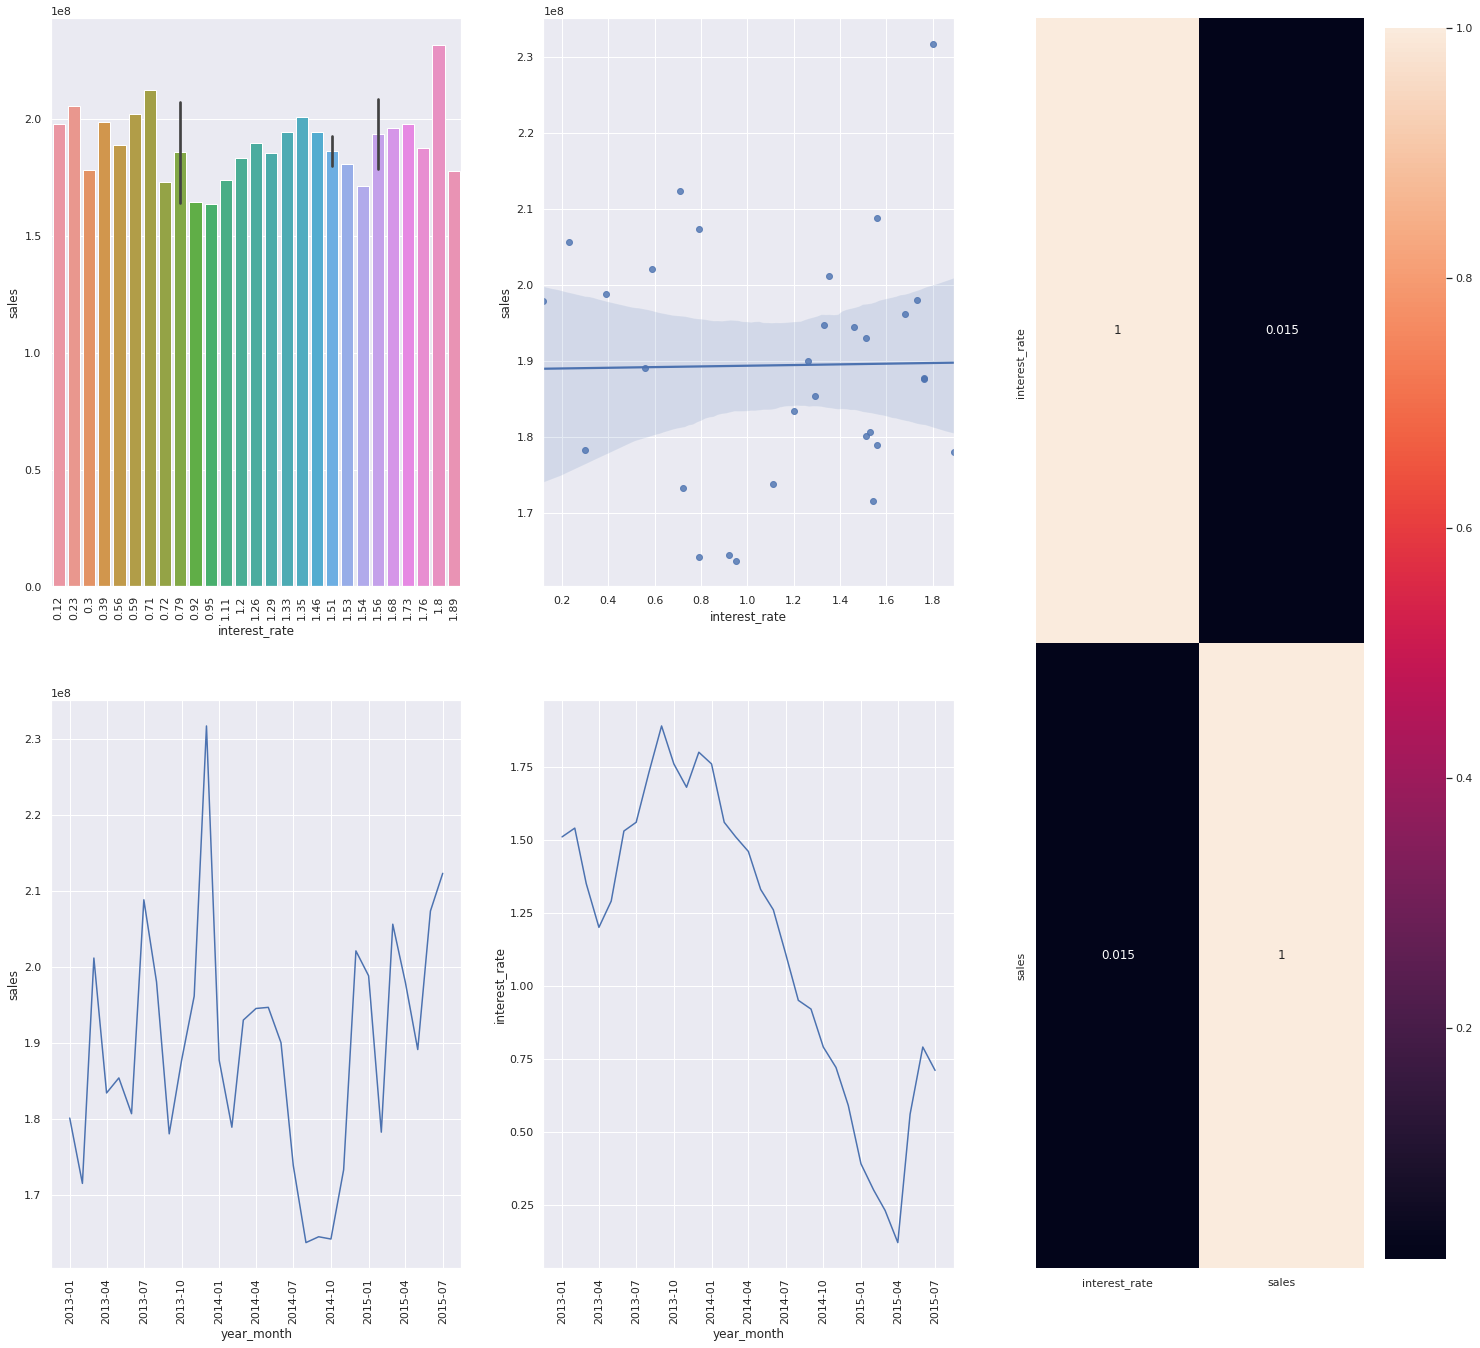

In [68]:
aux1 = df4[['year_month', 'interest_rate','sales']].groupby(['year_month','interest_rate']).sum().reset_index()

grid = GridSpec(2,3)

plt.figure(figsize = (25,23))

plt.subplot(grid[0,0])
sns.barplot(x = 'interest_rate', y = 'sales', data = aux1);
plt.xticks(rotation = 90);

plt.subplot(grid[0,1])
sns.regplot(x = 'interest_rate', y = 'sales', data = aux1);

plt.subplot(grid[1,0])
sns.lineplot(x = 'year_month', y = 'sales', data = aux1);
plt.xticks(rotation = 90);

plt.subplot(grid[:,2])
aux2 = aux1[['interest_rate','sales']]
sns.heatmap(aux2.corr(), annot = True);

plt.subplot(grid[1,1])
sns.lineplot(x = 'year_month', y = 'interest_rate', data = aux1);
plt.xticks(rotation = 90);

### **H17.**  Stores sales increase when Consumer Price Index (CPI) rate increases (month)  
**TRUE**: Store sales increase when inflation increases.

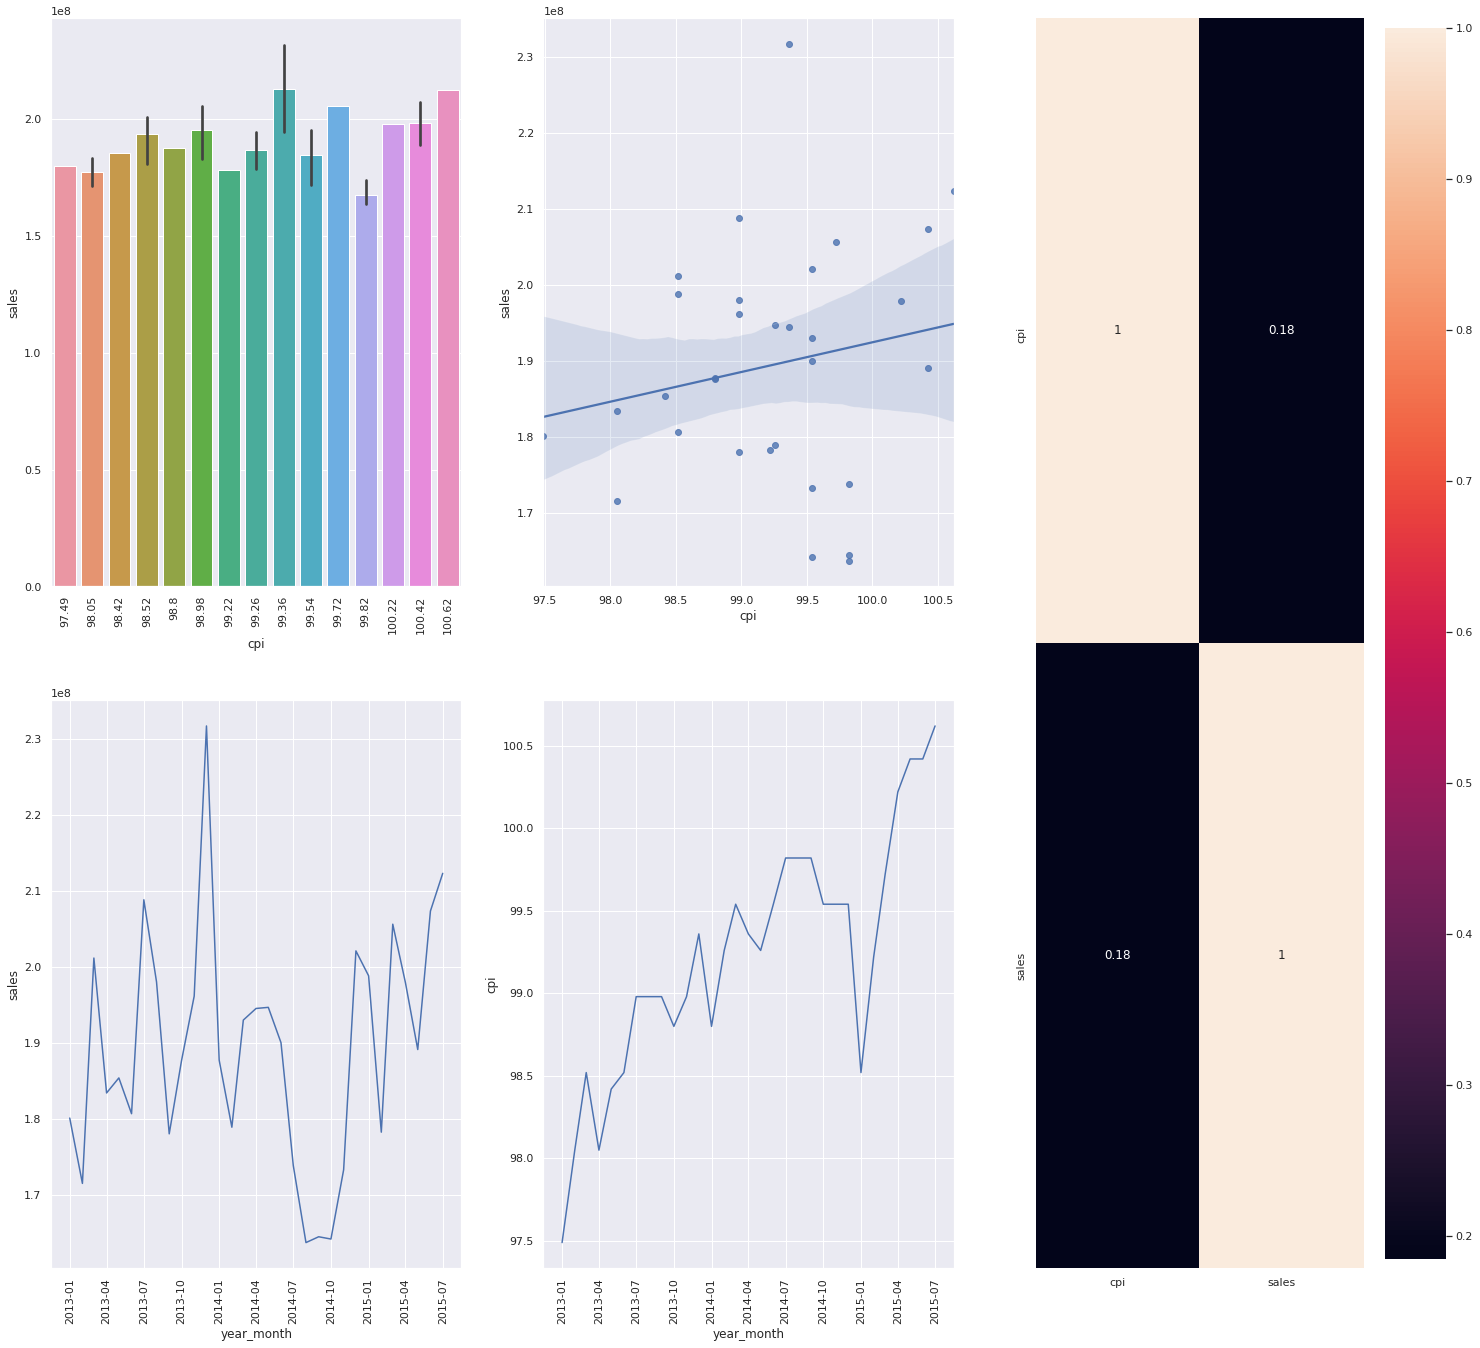

In [69]:
aux1 = df4[['year_month', 'cpi','sales']].groupby(['year_month','cpi']).sum().reset_index()

grid = GridSpec(2,3)

plt.figure(figsize = (25,23))

plt.subplot(grid[0,0])
aux3 = aux1
aux3['cpi'] = round(aux3['cpi'], 2)
sns.barplot(x = 'cpi', y = 'sales', data = aux3);
plt.xticks(rotation = 90);

plt.subplot(grid[0,1])
sns.regplot(x = 'cpi', y = 'sales', data = aux1);

plt.subplot(grid[1,0])
sns.lineplot(x = 'year_month', y = 'sales', data = aux1);
plt.xticks(rotation = 90);

plt.subplot(grid[:,2])
aux2 = aux1[['cpi','sales']]
sns.heatmap(aux2.corr(), annot = True);

plt.subplot(grid[1,1])
sns.lineplot(x = 'year_month', y = 'cpi', data = aux1);
plt.xticks(rotation = 90);

### 4.3. Hypotheses Validation

In [72]:
from tabulate import tabulate

In [73]:
tab =[['Hypothesis', 'Result', 'Relevancy'],
      ['H1', 'False', 'High'],  
      ['H2', 'False', 'High'],  
      ['H3', 'False', 'High'],
      ['H4', 'True', 'High'],
      ['H5', 'False', 'Medium'],
      ['H6', 'False', 'Low'],
      ['H7', 'True', 'Low'],
      ['H8', 'False', 'Medium'],
      ['H9', 'False', 'Medium'],
      ['H10', 'True', 'Low'],
      ['H11', 'True', 'High'],
      ['H12', 'True', 'Low'],
      ['H13', 'False', 'High'],
      ['H14', 'True', 'High'],
      ['H15', 'False', 'Low'],
      ['H16', 'False', 'Low'],
      ['H17', 'True', 'Low'],
     ]  
print( tabulate( tab, headers='firstrow' ) )



Hypothesis    Result    Relevancy
------------  --------  -----------
H1            False     High
H2            False     High
H3            False     High
H4            True      High
H5            False     Medium
H6            False     Low
H7            True      Low
H8            False     Medium
H9            False     Medium
H10           True      Low
H11           True      High
H12           True      Low
H13           False     High
H14           True      High
H15           False     Low
H16           False     Low
H17           True      Low


## 4.3. Multivariate Analysis

### 4.3.1. Numerical Variables

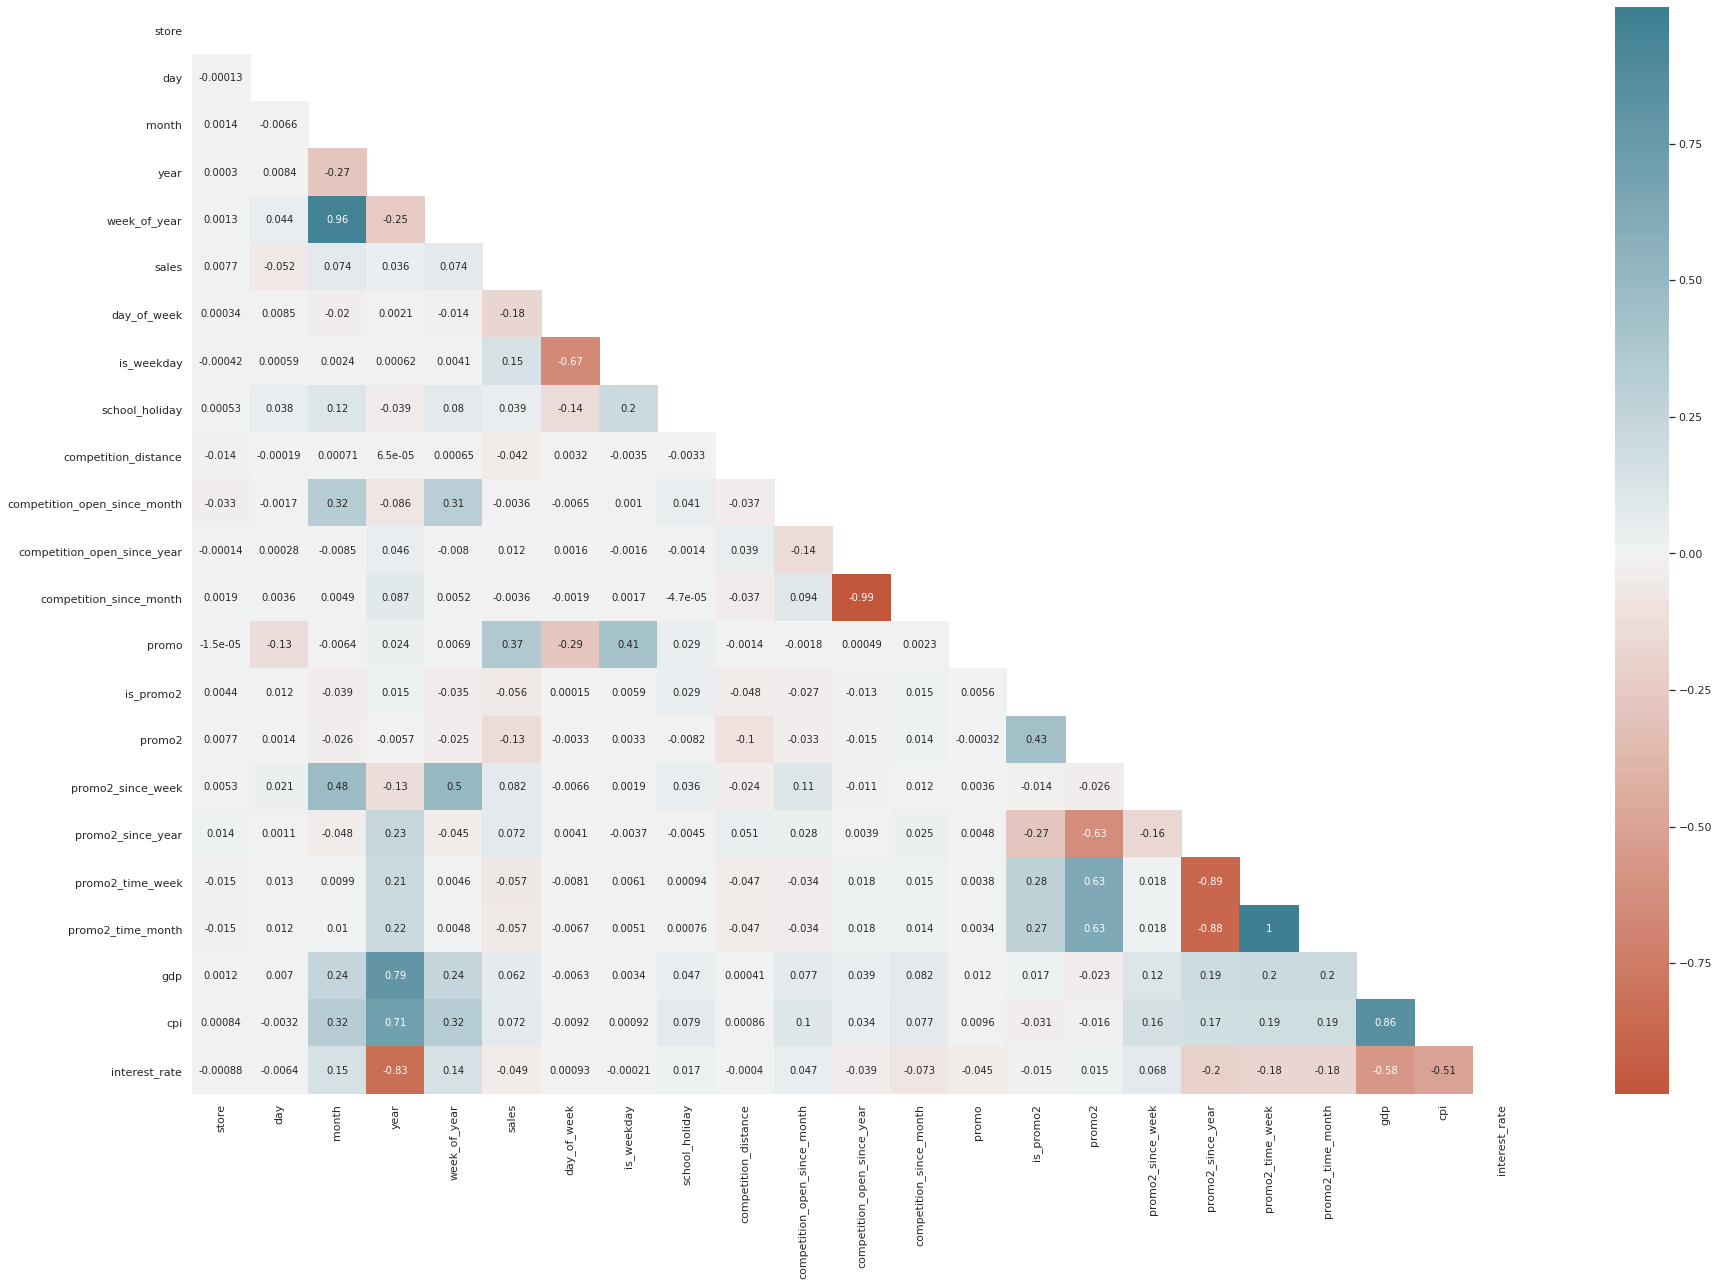

In [74]:
## Plot fig sizing. 
style.use('ggplot')
sns.set_style('whitegrid')
plt.subplots(figsize = (30,20))
## Plotting heatmap. 

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(num_feat.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


sns.heatmap(num_feat.corr(), 
            cmap=sns.diverging_palette(20, 220, n=200), 
            mask = mask, 
            annot=True, 
            center = 0, 
           );


**Multicollinearity**  
Negative correlation:  
1. competition_open_since_year vs competition_open_since_month    
2. year vs interest_rate  
3. promo2_since_year vs promo2_time_month  
4. promo2_since_year vs promo2_time_week  
5. day_of_week vs is_weekday  
  
Positive correlation:  
1. month vs week_of_year  
2. gdp vs year  
3. cpi vs year  
4. gdp vs cpi  
5. promo2 vs promo2_time_week  
6. promo2 vs promo2_time_month  

**Correlation with sales**
Strong: -  
Medium: promo  
Weak: is_weekday  
Around zero but positive: school_holiday, gdp, cpi, promo2_since_year, promo2_since_week, competition_open_since_year  

### 4.3.1. Categorical Variables

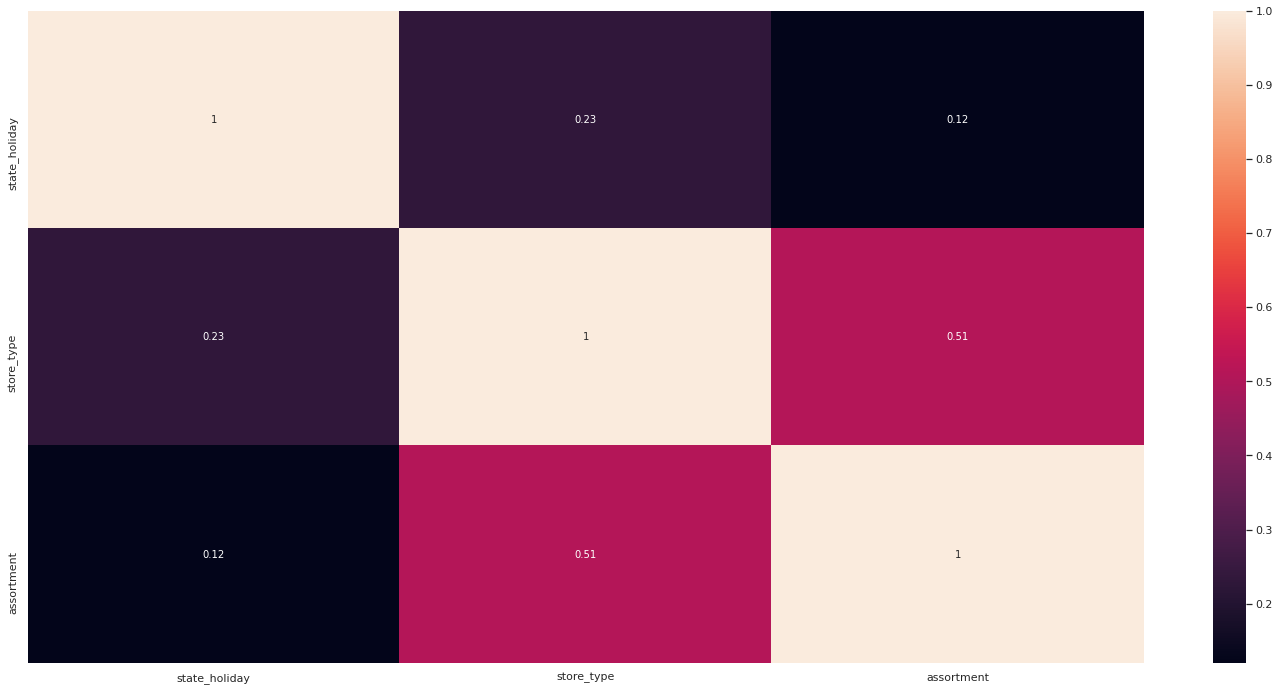

In [81]:
# calculating cramer_V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame({'state_holiday': [a1,a2,a3],
                  'store_type':[a4,a5,a6],
                  'assortment': [a7,a8,a9]})

d = d.set_index(d.columns)
sns.heatmap( d, annot=True );

**Multicollinearity**  
1. store_type and assortment have a mild correlation

# 5.0. STEP 05 - DATA PRE-PROCESSING

In [82]:
df5 = df4.copy()

In [83]:
df5.dtypes

store                                    int64
date                            datetime64[ns]
day                                      int64
month                                    int64
year                                     int64
year_month                      datetime64[ns]
week_of_year                             int64
year_week                               object
sales                                    int64
day_of_week                              int64
is_weekday                               int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
competition_since               datetime64[ns]
competition_since_month                  int64
promo                                    int64
is_promo2    

## 5.1. Standardization
No variable to be standardized

## 5.2. Rescaling

In [8]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

In [79]:
rs = RobustScaler()
mms = MinMaxScaler()

In [80]:
## RobustScaler
# competition_distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values)
# competition_since_month (months of competition since it started)
df5['competition_since_month'] = rs.fit_transform( df5[['competition_since_month']].values)

## MinMaxScaler
# promo2_time_week (weeks of promo2 since it started)
df5['promo2_time_week'] = mms.fit_transform( df5[['promo2_time_week']].values)
# promo2_time_month (months of promo2 since it started)
df5['promo2_time_month'] = mms.fit_transform( df5[['promo2_time_month']].values)

# gdp
df5['gdp'] = mms.fit_transform( df5[['gdp']].values)

# cpi
df5['cpi'] = mms.fit_transform( df5[['cpi']].values)

# interest_rate
df5['interest_rate'] = mms.fit_transform( df5[['interest_rate']].values)

# year
df5['year'] = mms.fit_transform( df5[['year']].values)


## 5.3. Transformation

### 5.3.1. Categorical Encoding

In [9]:
# df5.to_csv(r'data/df5.csv', index = False)
df5 = pd.read_csv('data/df5.csv', low_memory = False)

In [10]:
# state_holiday (One Hot Encoding)
df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])
# store_type
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
# assortment
assortment_dict = {'basic': 1,  'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

### 5.3.2. Response Variable Transformation

In [11]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3. Nature Transformation (cyclic)

In [12]:
## nature transform
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2*np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: sin(x*(2*np.pi/12)))
# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: sin(x*(2*np.pi/30)))
# week_of_year (W)
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: sin(x*(2*np.pi/52)))
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: sin(x*(2*np.pi/7)))

# 6.0. STEP 06 - FEATURE SELECTION

In [13]:
df6 = df5.copy()

## 6.1. Split Dataframe (train/validation)

In [14]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo2_since', 'competition_since', 'year_week', 'year_month' ]
df6 = df6.drop( cols_drop, axis=1 )
df6['date'] = pd.to_datetime(df6['date'])
# last 6 weeks as validation data
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6*7)

Timestamp('2015-06-19 00:00:00')

In [15]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# validation dataset
X_valid = df6[df6['date'] >= '2015-06-19']
y_valid = X_valid['sales']

# checking dates
print( 'Train min date:{}'.format(X_train['date'].min()))
print( 'Train max date:{}'.format(X_train['date'].max()))
print( '\nValid min date:{}'.format(X_valid['date'].min()))
print( 'Valid max date:{}'.format(X_valid['date'].max()))

Train min date:2013-01-01 00:00:00
Train max date:2015-06-18 00:00:00

Valid min date:2015-06-19 00:00:00
Valid max date:2015-07-31 00:00:00


## 6.2. Feature Selector (Boruta)

In [16]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

In [22]:
# transforming training and validation dataset into numpy array
X_train_n = X_train.drop(['date','sales'], axis = 1).values
y_train_n = y_train.values.ravel() # ravel flattens all numbers into a 1-D array

# Model to be used on boruta
rf = RandomForestRegressor(n_jobs = -1)

#Defining Boruta
boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 42).fit(X_train_n, y_train_n) 
# rf = random forest, 'auto' = automatic selection of # trees, 'verbose' plotting each step
# be careful = you can't pass a dataframe inside .fit